# Import librerie

Import delle librerie e del dataset

In [1]:
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
import scipy.stats as stats 
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import rpy2

# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/Progetto SDMTSA/data2022_train.csv"
data = pd.read_csv(path)

In [4]:
print(data.head())

            Unnamed: 0            y
0  2017-01-01 00:00:00  34055.69620
1  2017-01-01 00:10:00  29814.68354
2  2017-01-01 00:20:00  29128.10127
3  2017-01-01 00:30:00  28228.86076
4  2017-01-01 00:40:00  27335.69620


# Pre-processing

Cambio il nome alle colonne

In [5]:
data = data.rename(columns = {'Unnamed: 0':'Date', 'y':'Value'}, inplace = False)

In [6]:
print(data.head())

                  Date        Value
0  2017-01-01 00:00:00  34055.69620
1  2017-01-01 00:10:00  29814.68354
2  2017-01-01 00:20:00  29128.10127
3  2017-01-01 00:30:00  28228.86076
4  2017-01-01 00:40:00  27335.69620


## Valori nulli e/o duplicati

Vediamo se ci sono valori nulli e/o valori NA e/o valori duplicati.

In [7]:
print(data['Value'].isnull())

0        False
1        False
2        False
3        False
4        False
         ...  
48091    False
48092    False
48093    False
48094    False
48095    False
Name: Value, Length: 48096, dtype: bool


In [8]:
print(data.isnull().sum())

Date     0
Value    0
dtype: int64


In [9]:
print(sum(data.duplicated()))

0


In [10]:
data.isnull().values.any()

False

In [11]:
data.isna().any(axis=None)

False

Non ci sono missing values, né valori NA, né valori mancanti.

## Manipolazione della data e creazione di colonne aggiuntive

Trasformo la colonna Date in datetime

In [12]:
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
print(data.head())

                 Date        Value
0 2017-01-01 00:00:00  34055.69620
1 2017-01-01 00:10:00  29814.68354
2 2017-01-01 00:20:00  29128.10127
3 2017-01-01 00:30:00  28228.86076
4 2017-01-01 00:40:00  27335.69620


Faccio una divisione della data in: anno, giorno, mese, ora, minuti, secondi

In [14]:
data['Year'] = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Day'] = data.Date.dt.day
data['Hour'] = data.Date.dt.hour
data['Minute'] = data.Date.dt.minute
data['Second'] = data.Date.dt.second
data['WeekDay'] = data.Date.dt.day_name()
data['Month_Name'] = data.Date.dt.strftime("%B")

data['Num_DayofYear'] = data['Date'].dt.dayofyear
data['Num_DayofWeek'] = data['Date'].dt.dayofweek
data['Num_WeekofYear'] = data['Date'].dt.isocalendar().week

data['Quarter'] = data['Date'].dt.quarter

data['Just_Date'] = data['Date'].dt.date

Set della data comoleta come index

In [15]:
data.set_index(data['Date'], inplace = True)

In [16]:
data = data.drop(['Date'], axis = 1)
data['Month_Name'] = data.index.strftime("%B")

In [17]:
print(data.head())

                           Value  Year  Month  Day  Hour  Minute  Second  \
Date                                                                       
2017-01-01 00:00:00  34055.69620  2017      1    1     0       0       0   
2017-01-01 00:10:00  29814.68354  2017      1    1     0      10       0   
2017-01-01 00:20:00  29128.10127  2017      1    1     0      20       0   
2017-01-01 00:30:00  28228.86076  2017      1    1     0      30       0   
2017-01-01 00:40:00  27335.69620  2017      1    1     0      40       0   

                    WeekDay Month_Name  Num_DayofYear  Num_DayofWeek  \
Date                                                                   
2017-01-01 00:00:00  Sunday    January              1              6   
2017-01-01 00:10:00  Sunday    January              1              6   
2017-01-01 00:20:00  Sunday    January              1              6   
2017-01-01 00:30:00  Sunday    January              1              6   
2017-01-01 00:40:00  Sunday    Janu

In [18]:
print(data)

                           Value  Year  Month  Day  Hour  Minute  Second  \
Date                                                                       
2017-01-01 00:00:00  34055.69620  2017      1    1     0       0       0   
2017-01-01 00:10:00  29814.68354  2017      1    1     0      10       0   
2017-01-01 00:20:00  29128.10127  2017      1    1     0      20       0   
2017-01-01 00:30:00  28228.86076  2017      1    1     0      30       0   
2017-01-01 00:40:00  27335.69620  2017      1    1     0      40       0   
...                          ...   ...    ...  ...   ...     ...     ...   
2017-11-30 23:10:00  31347.69231  2017     11   30    23      10       0   
2017-11-30 23:20:00  30603.07692  2017     11   30    23      20       0   
2017-11-30 23:30:00  29889.23077  2017     11   30    23      30       0   
2017-11-30 23:40:00  29249.23077  2017     11   30    23      40       0   
2017-11-30 23:50:00  28584.61538  2017     11   30    23      50       0   

           

# Analisi Esplorativa

## Rappresentazioni per granularità della serie

Serie storica vista nella sua totalità.

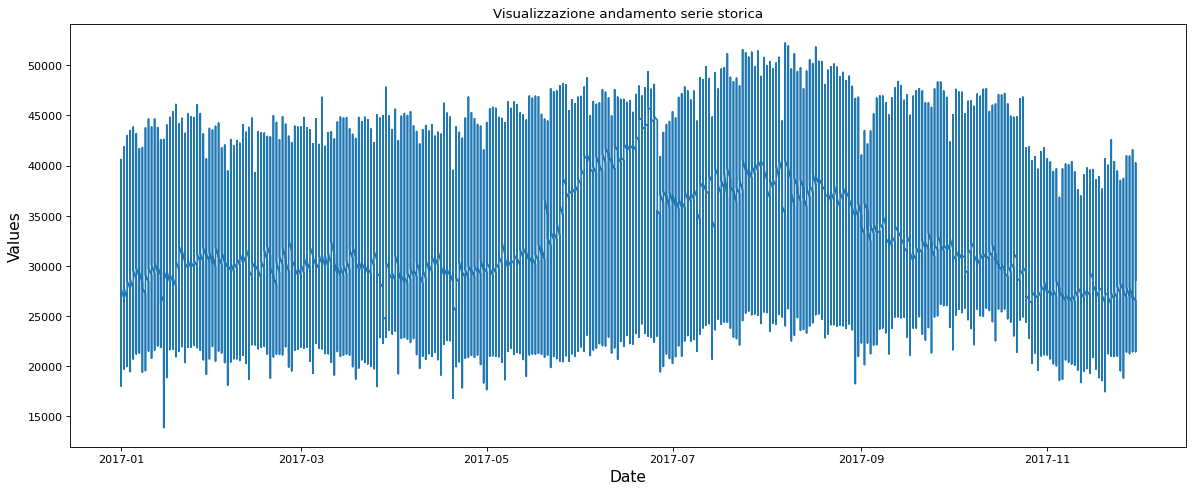

In [19]:
figure(figsize=(18, 7), dpi=80, linewidth=10)
plt.plot(data['Just_Date'], data['Value'])
plt.title('Visualizzazione andamento serie storica')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.show()

Serie storica vista nella sua totalità, ma con granularità GIORNALIERA.

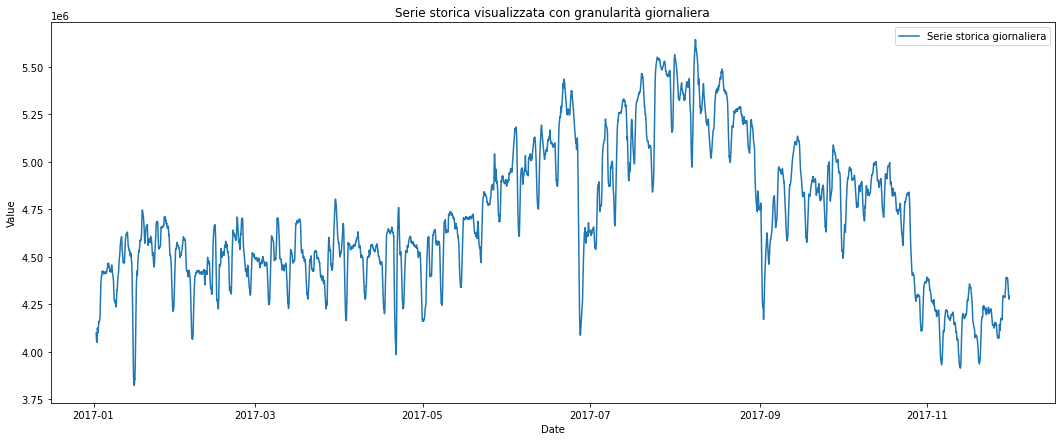

In [20]:
# Calcolo la media rolling giornaliera della serie storica
serie_giorn = data['Value'].rolling(window=144).sum() #144 è 24*6 quindi un giorno 
                                                        #144 giornaliera, 1008 settimanale, 4032 mensile
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_giorn, label="Serie storica giornaliera")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità giornaliera")
plt.legend()
plt.show()

Serie storica vista nella sua totalità, ma con granularità SETTIMANALE.

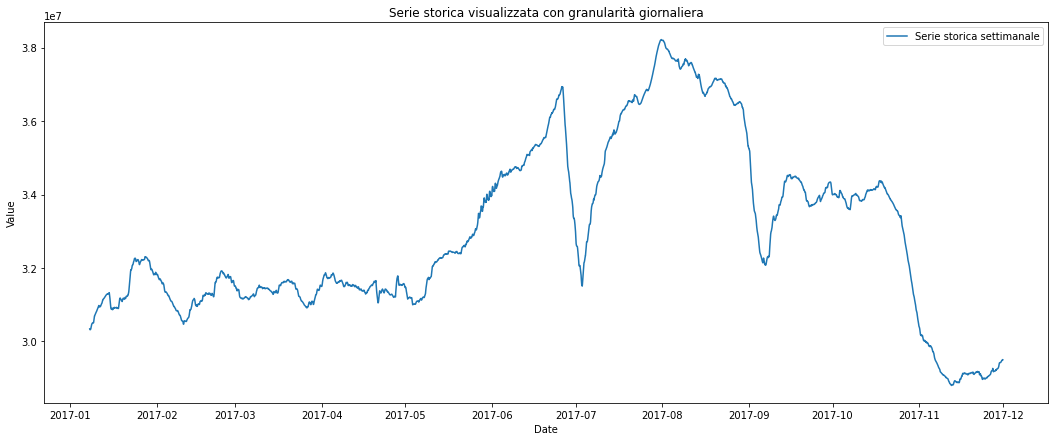

In [21]:
# Calcolo la media rolling giornaliera della serie storica
serie_sett = data['Value'].rolling(window=1008).sum() #1008 settimanale, 6*24*7
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_sett, label="Serie storica settimanale")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità giornaliera")
plt.legend()
plt.show()

Serie storica vista nella sua totalità, ma con granularità MENSILE.

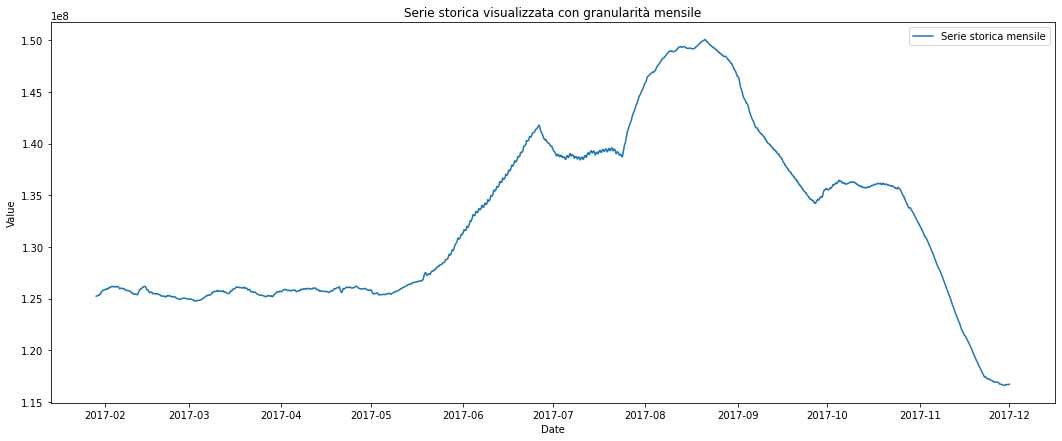

In [22]:
# Calcolo la media rolling giornaliera della serie storica
serie_mensile = data['Value'].rolling(window=4032).sum() # 4032 mensile, 6*24*7*4
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(serie_mensile, label="Serie storica mensile")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Serie storica visualizzata con granularità mensile")
plt.legend()
plt.show()

## Altre analisi

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


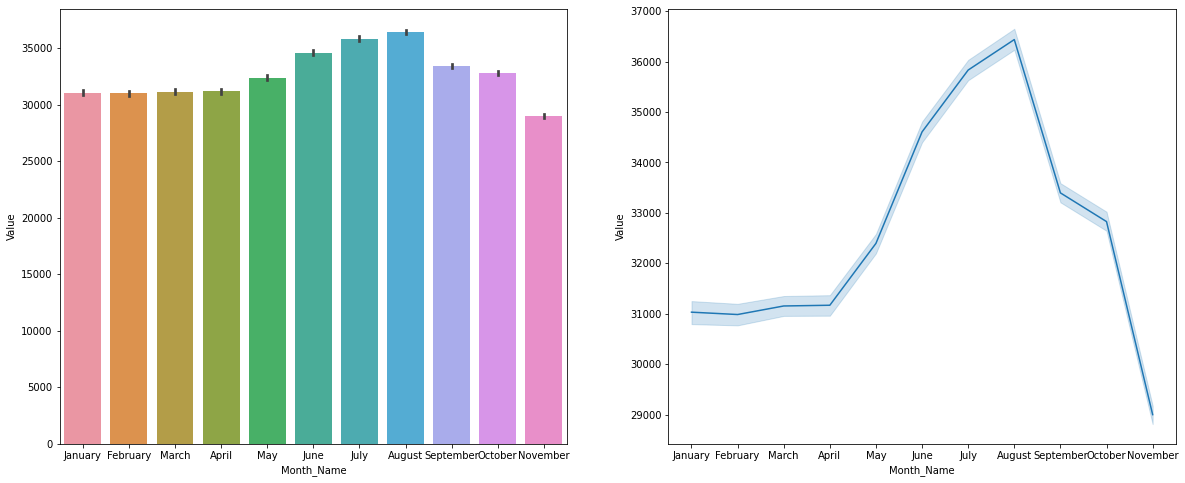

In [23]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Month_Name'], data['Value'], ax = ax[0])
sns.lineplot(data['Month_Name'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


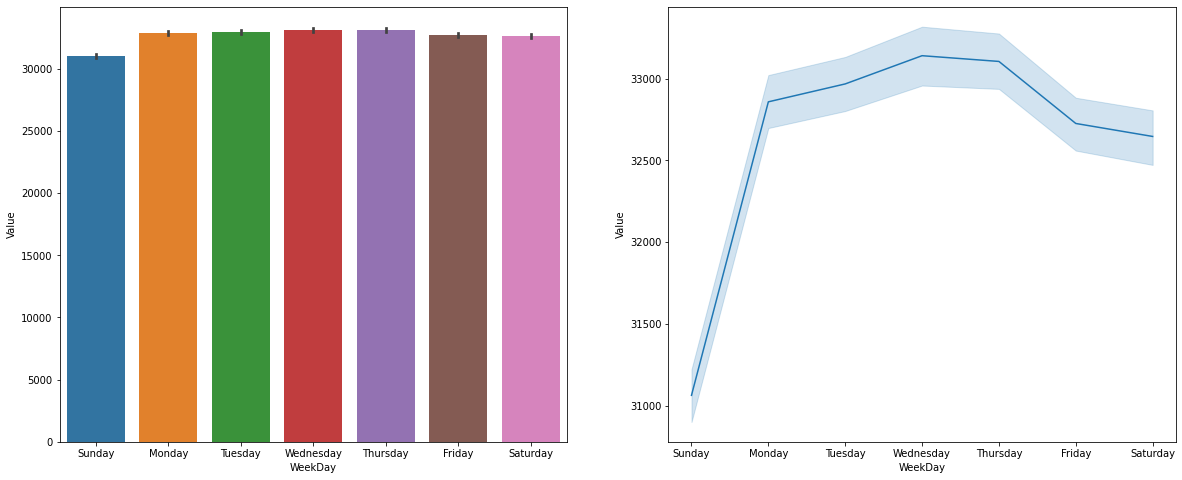

In [24]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['WeekDay'], data['Value'], ax = ax[0])
sns.lineplot(data['WeekDay'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


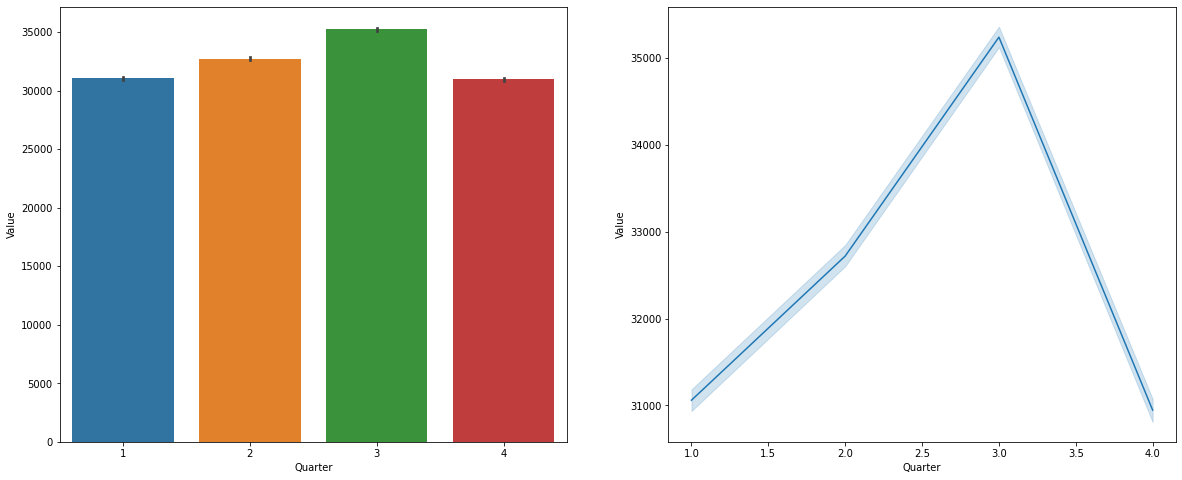

In [25]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Quarter'], data['Value'], ax = ax[0])
sns.lineplot(data['Quarter'], data['Value'], ax = ax[1])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


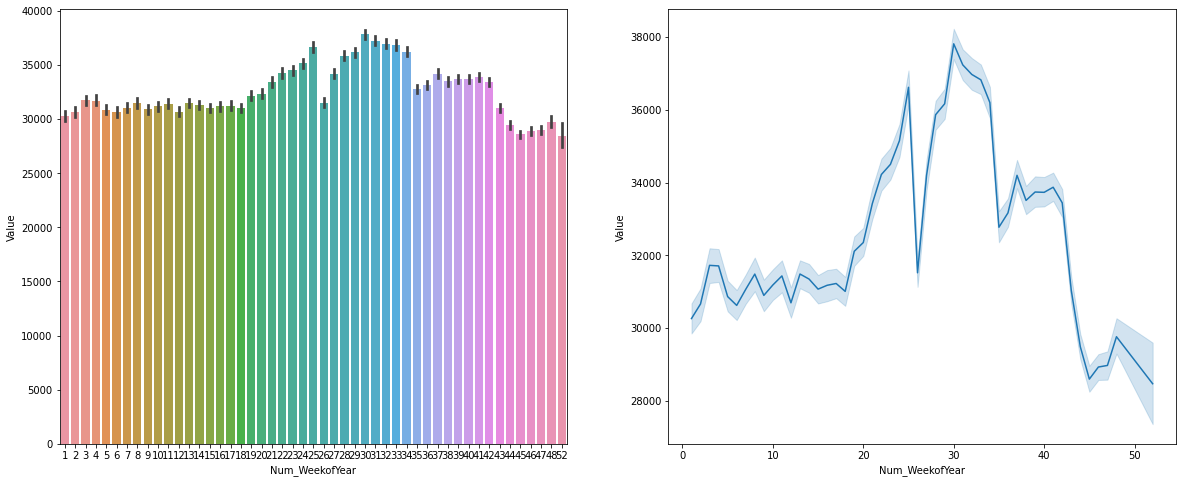

In [26]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize = (20, 8))
sns.barplot(data['Num_WeekofYear'], data['Value'], ax = ax[0])
sns.lineplot(data['Num_WeekofYear'], data['Value'], ax = ax[1])

### Andamento in funzione dell'ora del giorno

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


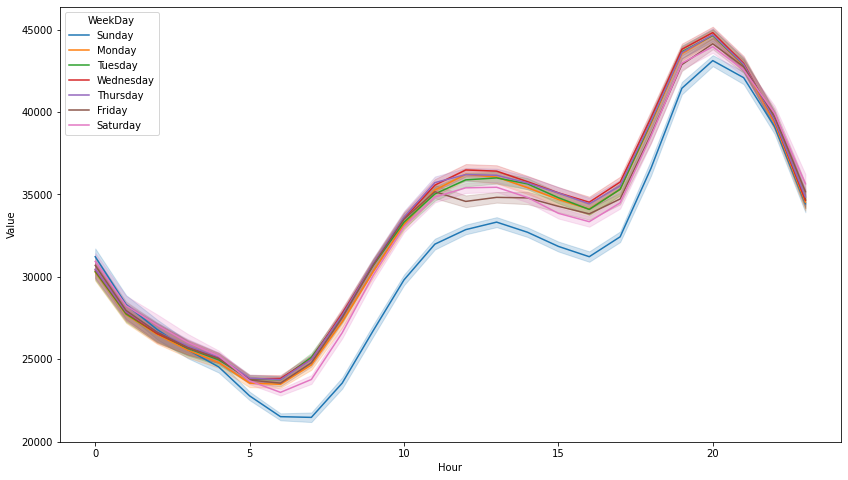

In [27]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['Hour'], data['Value'], hue = data['WeekDay'])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


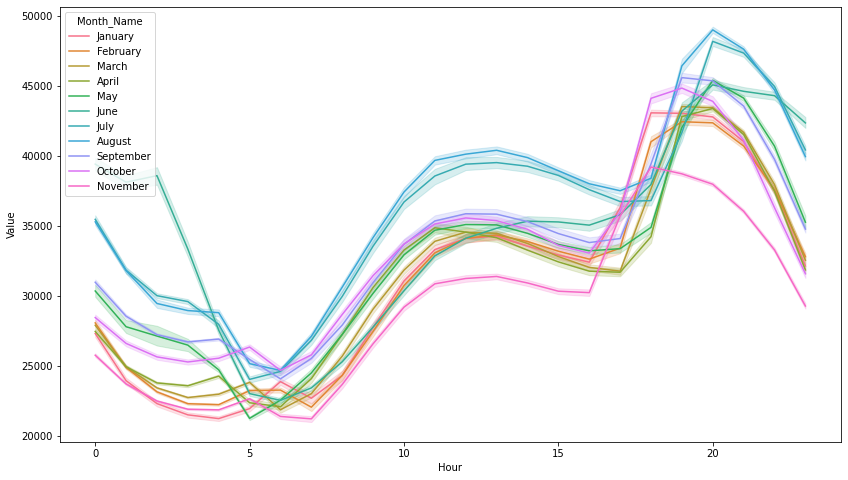

In [28]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['Hour'], data['Value'], hue = data['Month_Name'])
plt.xlabel('Hour')
plt.ylabel('Value')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


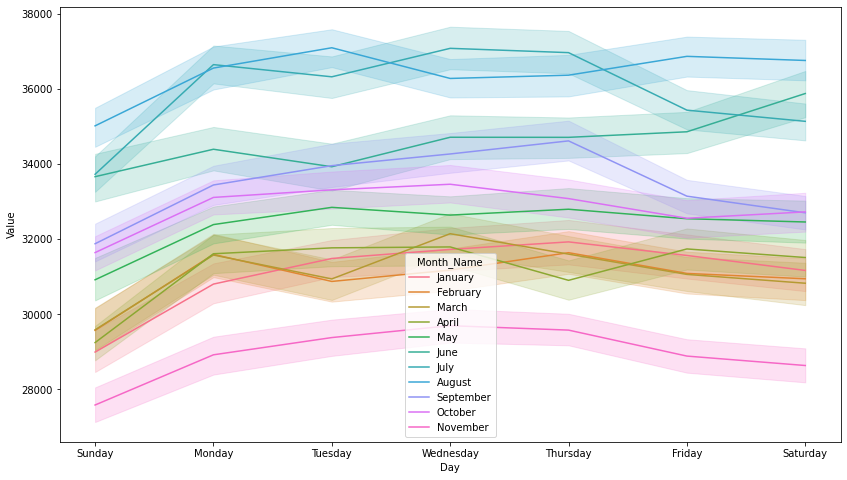

In [29]:
plt.figure(figsize=(14, 8))
sns.lineplot(data['WeekDay'], data['Value'], hue = data['Month_Name'])
plt.xlabel('Day')
plt.ylabel('Value')
plt.show()

### Boxplot

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-pack

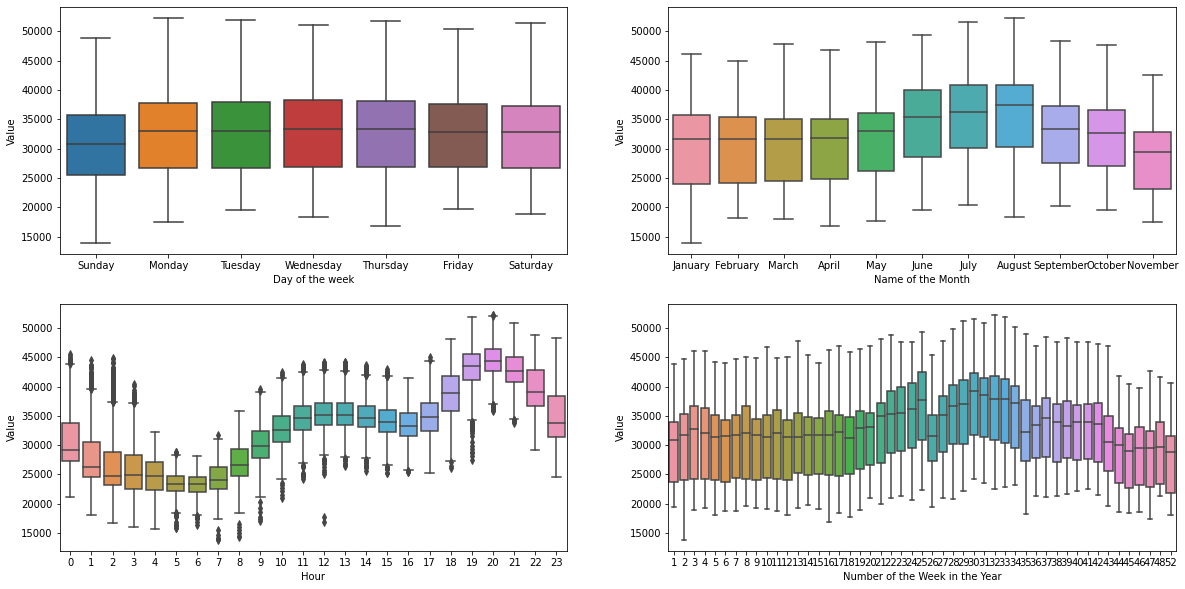

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.boxplot(data['WeekDay'], data['Value'], ax=ax[0][0]) #giorno della settimana
ax[0][0].set_xlabel('Day of the week')
ax[0][0].set_ylabel('Value')

sns.boxplot(data['Hour'], data['Value'], ax=ax[1][0]) #ora
ax[1][0].set_xlabel('Hour')
ax[1][0].set_ylabel('Value')

sns.boxplot(data['Month_Name'], data['Value'], ax=ax[0][1]) #mese
ax[0][1].set_xlabel('Name of the Month')
ax[0][1].set_ylabel('Value') 

sns.boxplot(data['Num_WeekofYear'], data['Value'], ax=ax[1][1]) #numero della settimana
ax[1][1].set_xlabel('Number of the Week in the Year')
ax[1][1].set_ylabel('Value')

plt.show()

Andamento all'interno della settimana abbastanza simile (si abbassa la domenica).
Giugno luglio e agosto in crescita, poi scende di nuovo a settembre, novembre valori più bassi. 
Durante il giorno le ore con consumi più bassi sono le 5,6,7, mentre quelle con consumi maggiori sono le 19 e le 20.
Settimana 26 segna discesa significativa, poi risale e torna a scendere alla 42 (con 44 picco negativo).

# Analisi Serie Storica

## Divisione train validation

Divido in train set e validation set.

In [31]:
train_set = data.loc[ : "2017-10-31 23:50:00"]
validation_set = data.loc["2017-11-01 00:00:00" : ]

In [32]:
validation_set

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01
2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30


## Definizione funzioni per calcolo ADF e KPSS

In [33]:
# ADF Test
def run_adf_test(x):
    result_ADF = adfuller(x.values, autolag='AIC')
    print(f'ADF Statistic: {result_ADF[0]}')
    print(f'p-value: {result_ADF[1]}')
    for key, value in result_ADF[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_ADF[1] < 0.05:
        print("The time series is stationary in mean.")
    else:
        print("The time series is not stationary in mean.")

In [34]:
# KPSS Test
def run_kpss_test(x):
    result_KPSS = kpss(x.values, regression='c')
    print('\nKPSS Statistic: %f' % result_KPSS[0])
    print('p-value: %f' % result_KPSS[1])
    for key, value in result_KPSS[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

    if result_KPSS[1] < 0.05:
        print("The time series is not stationary in variance.")
    else:
        print("The time series is stationary in variance.")

### Calcolo valori dei test sulla serie storica

#### ADF

Controllo stazionarietà in media con ADF.

https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
https://www.machinelearningplus.com/time-series/time-series-analysis-python/ punto 10

In [35]:
resultADF = run_adf_test(data['Value'])

ADF Statistic: -33.537036738955436
p-value: 0.0
Critical Values:
   1%, -3.4304861235884645
Critical Values:
   5%, -2.8616001637764574
Critical Values:
   10%, -2.56680202319782
The time series is stationary in mean.


AD dice che la serie storica è stazionaria in media, rigetto l'ipotesi nulla di non stazionarietà (p-value inferiore a 0.05). Stazionaria in media.

Plot della media della serie storica.

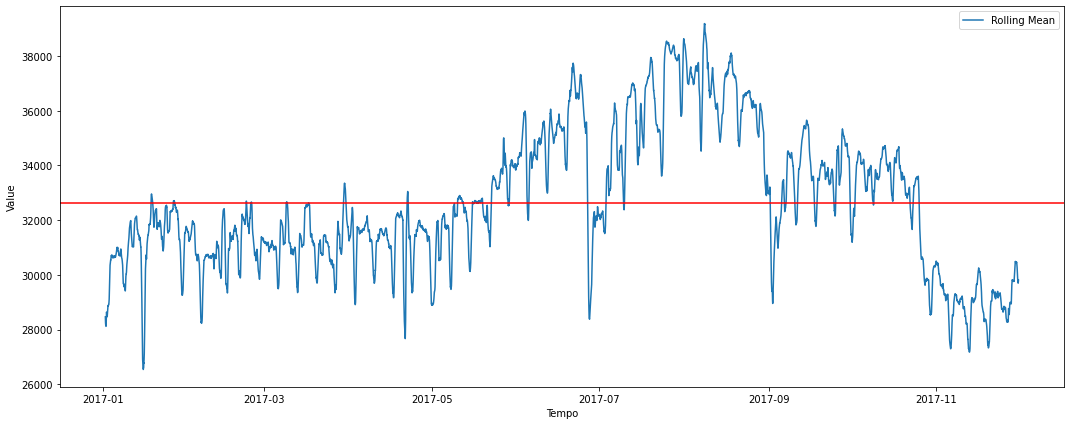

In [36]:
# Calcolo la media rolling giornaliera della serie storica
rolling_mean = data['Value'].rolling(window=144).mean() #144 è 24*6 quindi un giorno 
                                                        #144 giornaliera, 1008 settimanale, 4032 mensile
                                    
# Plot serie storica + media rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_mean, label="Rolling Mean")
plt.axhline(data['Value'].mean(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

#### KPSS

Controllo stazionarietà in varianza con KPSS.

In [37]:
resultKPSS = run_kpss_test(data['Value'])


KPSS Statistic: 4.157840
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Rigetto l'ipotesi nulla di stazionarietà in varianza, KPSS mi dice che la serie storica non è stazionaria in varianza.
La serie storica non è stazionaria in varianza.

Plot della varianza della serie storica.

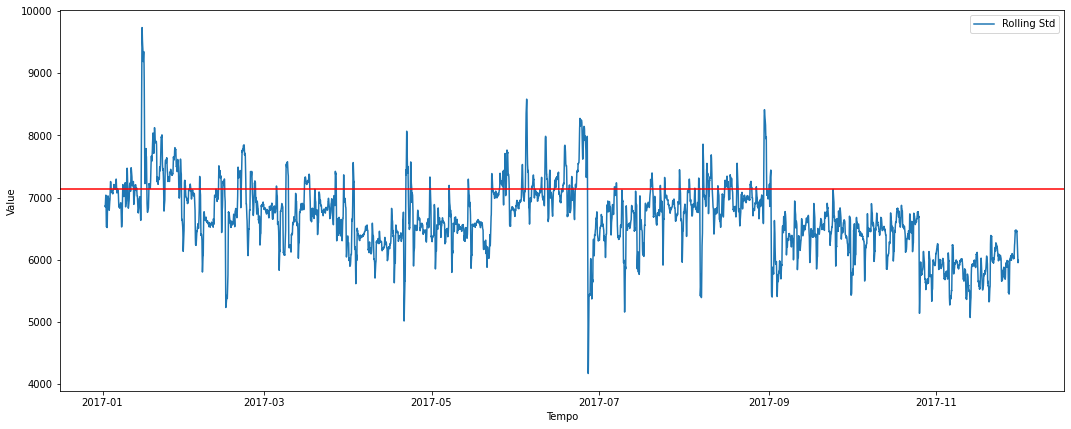

In [38]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value'].rolling(window=144).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std")
plt.axhline(data['Value'].std(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

"Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
Here, due to the difference in the results from ADF test and KPSS test, it can be inferred that the series is trend stationary and not strict stationary. The series can be detrended by differencing or by model fitting."

In [39]:
# Philips Perron test (PP Test)

In [40]:
#Breusch Godfrey Test
# from statsmodels.stats.diagnostic import acorr_breusch_godfrey

# test_result = acorr_breusch_godfrey(ts, model_fit)
# p_value = test_result[3]

# Trasformazioni

## Box-Cox

In [41]:
# Cerco il lambda ottimale
lambda_opt = boxcox_normmax(data['Value'])
print(lambda_opt)

# Applico Box-Cox con il lambda ottimale trovato
data['Value_BoxCox'] = boxcox(data['Value'], lmbda=lambda_opt)
print(data['Value_BoxCox'])

0.46800714402204047
Date
2017-01-01 00:00:00    280.250284
2017-01-01 00:10:00    263.209447
2017-01-01 00:20:00    260.331974
2017-01-01 00:30:00    256.508111
2017-01-01 00:40:00    252.645384
                          ...    
2017-11-30 23:10:00    269.509614
2017-11-30 23:20:00    266.470467
2017-11-30 23:30:00    263.519745
2017-11-30 23:40:00    260.842230
2017-11-30 23:50:00    258.028534
Name: Value_BoxCox, Length: 48096, dtype: float64


Testo ADF e KPSS

In [42]:
run_adf_test(data['Value_BoxCox'])

ADF Statistic: -33.370400406153365
p-value: 0.0
Critical Values:
   1%, -3.4304861264221036
Critical Values:
   5%, -2.8616001650288383
Critical Values:
   10%, -2.566802023864426
The time series is stationary in mean.


In [43]:
run_kpss_test(data['Value_BoxCox'])


KPSS Statistic: 4.171477
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Non cambia praticamente nulla, provo a procedere con una trasformazione logaritmica.

## Log

In [44]:
data['Value_Log'] = np.log(data['Value'])
print(data['Value_Log'])

Date
2017-01-01 00:00:00    10.435753
2017-01-01 00:10:00    10.302756
2017-01-01 00:20:00    10.279459
2017-01-01 00:30:00    10.248100
2017-01-01 00:40:00    10.215949
                         ...    
2017-11-30 23:10:00    10.352896
2017-11-30 23:20:00    10.328856
2017-11-30 23:30:00    10.305254
2017-11-30 23:40:00    10.283609
2017-11-30 23:50:00    10.260624
Name: Value_Log, Length: 48096, dtype: float64


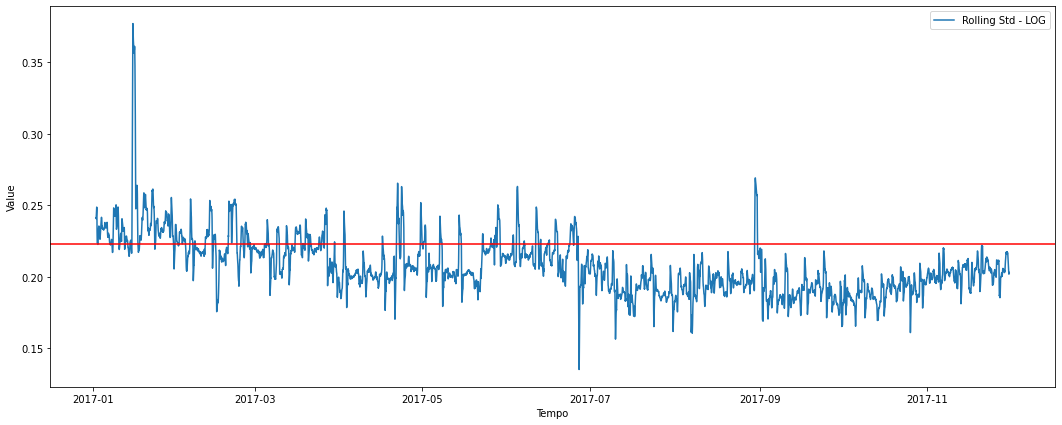

In [45]:
# Calcolo la deviazione standard rolling GIORNALIERA della serie storica
rolling_std = data['Value_Log'].rolling(window=144).std() #144 giornaliera, 1008 settimanale, 4032 mensile

# Plot serie storica + sd rolling
fig = plt.figure(figsize=(18, 7))

# plt.plot(data['Value'], label="Serie storica originale")
plt.plot(rolling_std, label="Rolling Std - LOG")
plt.axhline(data['Value_Log'].std(), color="red")  
plt.xlabel("Tempo")
plt.ylabel("Value")
plt.legend()
plt.show()

Riduce la varianza della serie storica.

Testo ADF e KPSS

In [46]:
run_adf_test(data['Value_Log'])

ADF Statistic: -33.28763630998326
p-value: 0.0
Critical Values:
   1%, -3.4304861264221036
Critical Values:
   5%, -2.8616001650288383
Critical Values:
   10%, -2.566802023864426
The time series is stationary in mean.


In [47]:
run_kpss_test(data['Value_Log'])


KPSS Statistic: 4.191695
p-value: 0.010000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is not stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Anche in questo caso non cambia praticamente nulla, dobbiamo procedere con una differenziazione (come suggerito anche dalla documentazione di statsmodels).

## Differenziazione

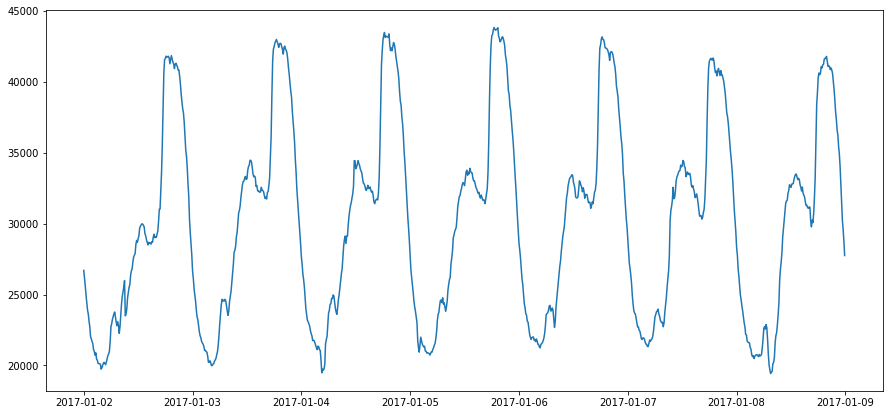

In [48]:
fig, ax = plt.subplots(1, 1, figsize =(15,7))
plt.plot(data[data['Num_WeekofYear'] == 1]['Value']) #plot della prima settimana di dati

Vedendo la prima settimana di dati si può vedere la presenza di una stagionalità giornaliera.

In [49]:
for i in range(1, data['Num_WeekofYear'].nunique()):
    fig, ax = plt.subplots(1, 1, figsize =(15,7))
    plt.plot(data[data['Num_WeekofYear'] == i]['Value'])

Output hidden; open in https://colab.research.google.com to view.

Procedo con la differenziazione giornaliera.

In [50]:
data_diff = data.copy()

In [51]:
data_diff['Value'] = data_diff['Value'].diff(144)
print(data_diff['Value']) #ci sono valori NA, quindi li devo droppare

Date
2017-01-01 00:00:00           NaN
2017-01-01 00:10:00           NaN
2017-01-01 00:20:00           NaN
2017-01-01 00:30:00           NaN
2017-01-01 00:40:00           NaN
                          ...    
2017-11-30 23:10:00    1347.69231
2017-11-30 23:20:00    1212.30769
2017-11-30 23:30:00    1286.15385
2017-11-30 23:40:00    1575.38462
2017-11-30 23:50:00    1600.00000
Name: Value, Length: 48096, dtype: float64


In [52]:
data_diff = data_diff.dropna()
print(data_diff['Value'])

Date
2017-01-02 00:00:00   -7351.89873
2017-01-02 00:10:00   -3645.56962
2017-01-02 00:20:00   -3505.82279
2017-01-02 00:30:00   -3256.70886
2017-01-02 00:40:00   -2898.22785
                          ...    
2017-11-30 23:10:00    1347.69231
2017-11-30 23:20:00    1212.30769
2017-11-30 23:30:00    1286.15385
2017-11-30 23:40:00    1575.38462
2017-11-30 23:50:00    1600.00000
Name: Value, Length: 47952, dtype: float64


Testo ADF e KPSS

In [53]:
run_adf_test(data_diff['Value'])

ADF Statistic: -19.459394832178386
p-value: 0.0
Critical Values:
   1%, -3.43048654140327
Critical Values:
   5%, -2.861600348437607
Critical Values:
   10%, -2.566802121487611
The time series is stationary in mean.


In [54]:
run_kpss_test(data_diff['Value'])


KPSS Statistic: 0.052548
p-value: 0.100000
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
The time series is stationary in variance.


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Tramite la differenziazione giornaliera si riesce a rendere la serie storica stazionaria anche in varianza.

### ACF e PACF

ACF e PACF 

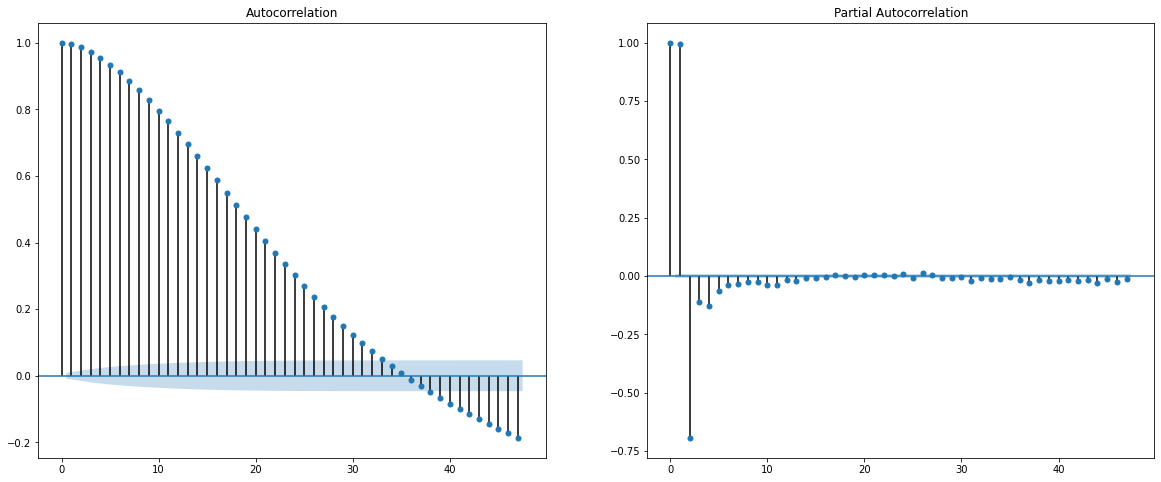

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data['Value'], ax = ax[0])
plot_pacf(data['Value'], ax = ax[1])

plt.show()

ACF rientra gradualmente verso 0, poi scende sotto lo 0: sembra oscillare. PACF esce fino al 15° ritardi circa.

ACF e PACF della serie storica differenziata.

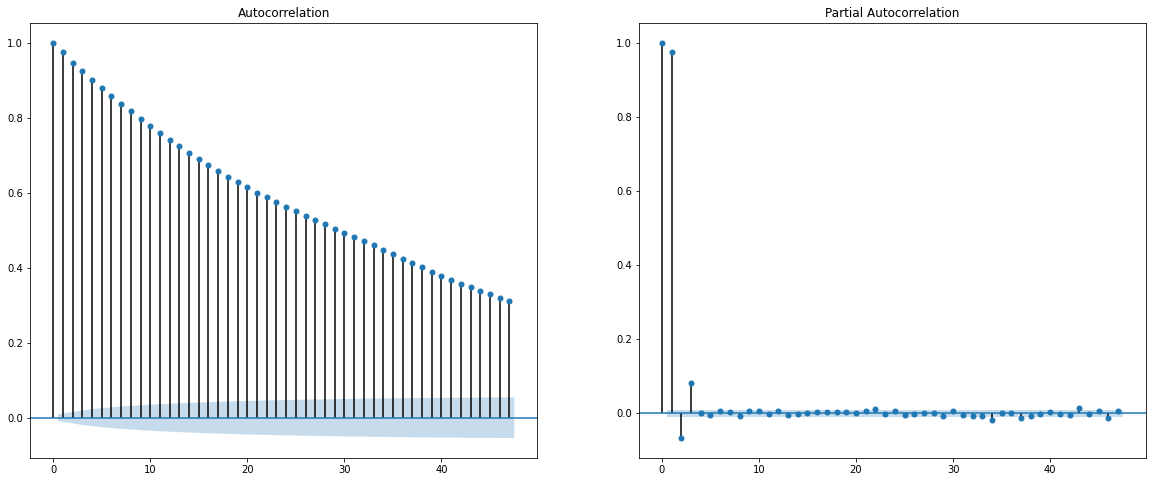

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20,8))
plot_acf(data_diff['Value'], ax = ax[0])
plot_pacf(data_diff['Value'], ax = ax[1])

plt.show()

ACF sta rientando gradualmente verso 0. PACF ha i primi 3 ritardi che escono. 

## Divisione train-validation serie

In [57]:
train_set_diff = data_diff.loc[ "2017-09-01 00:00:00": "2017-10-31 23:50:00"]
validation_set_diff = data_diff.loc["2017-11-01 00:00:00" : ]

In [58]:
train = data.loc[ "2017-09-01 00:00:00": "2017-10-31 23:50:00"]
validation = data.loc["2017-11-01 00:00:00" : ] 

#### Salvataggio

In [ ]:
validation.to_csv('validation.csv', index=False)
from google.colab import files
files.download('validation.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train.to_csv('train.csv', index=False)
from google.colab import files
files.download('train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TOTALE Arima OGNI 20 MINUTI
Train fino ad ottobre - validation novembre

In [59]:
train_tot = data.loc[ : "2017-10-31 23:50:00"]
validation_tot = data.loc["2017-11-01 00:00:00" : ] 

In [ ]:
train_tot.to_csv('train_tot.csv', index=True)
from google.colab import files
files.download('train_tot.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
validation_tot.to_csv('validation_tot.csv', index=True)
from google.colab import files
files.download('validation_tot.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Train Set


In [60]:
train_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
Date,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,52,1,2017-01-01,280.250284,10.435753
2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,52,1,2017-01-01,263.209447,10.302756
2017-01-01 00:20:00,29128.10127,2017,1,1,0,20,0,Sunday,January,1,6,52,1,2017-01-01,260.331974,10.279459
2017-01-01 00:30:00,28228.86076,2017,1,1,0,30,0,Sunday,January,1,6,52,1,2017-01-01,256.508111,10.248100
2017-01-01 00:40:00,27335.69620,2017,1,1,0,40,0,Sunday,January,1,6,52,1,2017-01-01,252.645384,10.215949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 23:10:00,31024.59519,2017,10,31,23,10,0,Tuesday,October,304,1,44,4,2017-10-31,268.195663,10.342536
2017-10-31 23:20:00,30362.88840,2017,10,31,23,20,0,Tuesday,October,304,1,44,4,2017-10-31,265.481762,10.320976
2017-10-31 23:30:00,29625.55799,2017,10,31,23,30,0,Tuesday,October,304,1,44,4,2017-10-31,262.420370,10.296393


In [61]:
train_tot["Num_WeekofYear"] = train_tot["Num_WeekofYear"].replace(52, 0)
train_tot[["Num_WeekofYear","Value"]]

<ipython-input-61-1eab92659b5f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tot["Num_WeekofYear"] = train_tot["Num_WeekofYear"].replace(52, 0)


,Num_WeekofYear,Value
Date,,
2017-01-01 00:00:00,0,34055.69620
2017-01-01 00:10:00,0,29814.68354
2017-01-01 00:20:00,0,29128.10127
2017-01-01 00:30:00,0,28228.86076
2017-01-01 00:40:00,0,27335.69620
...,...,...
2017-10-31 23:10:00,44,31024.59519
2017-10-31 23:20:00,44,30362.88840
2017-10-31 23:30:00,44,29625.55799


In [62]:
train_tot0_10 = train_tot[train_tot['Minute'].isin([0, 10])]
train_tot20_30 = train_tot[train_tot['Minute'].isin([20, 30])]
train_tot40_50 = train_tot[train_tot['Minute'].isin([40, 50])]

In [63]:
train_tot0_10

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
Date,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,0,1,2017-01-01,280.250284,10.435753
2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,0,1,2017-01-01,263.209447,10.302756
2017-01-01 01:00:00,25998.98734,2017,1,1,1,0,0,Sunday,January,1,6,0,1,2017-01-01,246.736788,10.165813
2017-01-01 01:10:00,25446.07595,2017,1,1,1,10,0,Sunday,January,1,6,0,1,2017-01-01,244.245597,10.144317
2017-01-01 02:00:00,23003.54430,2017,1,1,2,0,0,Sunday,January,1,6,0,1,2017-01-01,232.879926,10.043404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-31 21:10:00,38744.50766,2017,10,31,21,10,0,Tuesday,October,304,1,44,4,2017-10-31,297.822797,10.564744
2017-10-31 22:00:00,35662.84464,2017,10,31,22,0,0,Tuesday,October,304,1,44,4,2017-10-31,286.410649,10.481865
2017-10-31 22:10:00,35246.91466,2017,10,31,22,10,0,Tuesday,October,304,1,44,4,2017-10-31,284.830758,10.470133


In [64]:
grouped_train_tot0_10 = train_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_train_tot20_30 = train_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_train_tot40_50 = train_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})

In [65]:
grouped_train_tot0_10

Value
Hour Num_DayofYear              
0    1              31935.189870
     2              26436.455695
     3              26406.075950
     4              27405.569620
     5              27189.873420
...                          ...
23   300            29909.146605
     301            29738.993435
     302            30312.472645
     303            30646.477025
     304            31538.205690

[7296 rows x 1 columns]

In [66]:
grouped_train_tot0_10_noind = grouped_train_tot0_10.reset_index()
grouped_train_tot20_30_noind = grouped_train_tot20_30.reset_index()
grouped_train_tot40_50_noind = grouped_train_tot40_50.reset_index()

In [67]:
grouped_train_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,1,31935.189870
1,0,2,26436.455695
2,0,3,26406.075950
3,0,4,27405.569620
4,0,5,27189.873420
...,...,...,...
7291,23,300,29909.146605
7292,23,301,29738.993435
7293,23,302,30312.472645
7294,23,303,30646.477025


In [68]:
grouped_train_tot0_10_noind['third_hour'] = 1
grouped_train_tot20_30_noind['third_hour'] = 2
grouped_train_tot40_50_noind['third_hour'] = 3

grouped_train_tot = pd.concat([grouped_train_tot0_10_noind,
                           grouped_train_tot20_30_noind,
                           grouped_train_tot40_50_noind], ignore_index=True)

In [69]:
grouped_train_tot

,Hour,Num_DayofYear,Value,third_hour
0,0,1,31935.189870,1
1,0,2,26436.455695,1
2,0,3,26406.075950,1
3,0,4,27405.569620,1
4,0,5,27189.873420,1
...,...,...,...,...
21883,23,300,27668.796500,3
21884,23,301,27435.623635,3
21885,23,302,27716.061270,3
21886,23,303,28327.352300,3


#### Save dataframes train_tot


In [70]:
grouped_train_tot.to_csv('grouped_train_tot_20min.csv', index=False)
from google.colab import files
files.download('grouped_train_tot_20min.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
# grouped_train_tot0_10_noind.to_csv('grouped_train_tot0_10_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_train_tot0_10_noind.csv')

In [72]:
# grouped_train_tot20_30_noind.to_csv('grouped_train_tot20_30_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_train_tot20_30_noind.csv')

In [73]:
# grouped_train_tot40_50_noind.to_csv('grouped_train_tot40_50_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_train_tot40_50_noind.csv')

### Validation Set

In [74]:
validation_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
Date,,,,,,,,,,,,,,,,
2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254


In [75]:
validation_tot["Num_WeekofYear"] = validation_tot["Num_WeekofYear"].replace(52, 0)
validation_tot[["Num_WeekofYear","Value"]]

<ipython-input-75-484048e91d6f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_tot["Num_WeekofYear"] = validation_tot["Num_WeekofYear"].replace(52, 0)


,Num_WeekofYear,Value
Date,,
2017-11-01 00:00:00,44,27089.23077
2017-11-01 00:10:00,44,26701.53846
2017-11-01 00:20:00,44,26375.38462
2017-11-01 00:30:00,44,25963.07692
2017-11-01 00:40:00,44,25593.84615
...,...,...
2017-11-30 23:10:00,48,31347.69231
2017-11-30 23:20:00,48,30603.07692
2017-11-30 23:30:00,48,29889.23077


In [76]:
validation_tot0_10 = validation_tot[validation_tot['Minute'].isin([0, 10])]
validation_tot20_30 = validation_tot[validation_tot['Minute'].isin([20, 30])]
validation_tot40_50 = validation_tot[validation_tot['Minute'].isin([40, 50])]

In [77]:
validation_tot20_30

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
Date,,,,,,,,,,,,,,,,
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
2017-11-01 01:20:00,24338.46154,2017,11,1,1,20,0,Wednesday,November,305,2,44,4,2017-11-01,239.167010,10.099813
2017-11-01 01:30:00,23920.00000,2017,11,1,1,30,0,Wednesday,November,305,2,44,4,2017-11-01,237.216366,10.082470
2017-11-01 02:20:00,23236.92308,2017,11,1,2,20,0,Wednesday,November,305,2,44,4,2017-11-01,233.992811,10.053498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 21:30:00,36436.92308,2017,11,30,21,30,0,Thursday,November,334,3,48,4,2017-11-30,289.325064,10.503338
2017-11-30 22:20:00,34510.76923,2017,11,30,22,20,0,Thursday,November,334,3,48,4,2017-11-30,282.010040,10.449027
2017-11-30 22:30:00,33803.07692,2017,11,30,22,30,0,Thursday,November,334,3,48,4,2017-11-30,279.268008,10.428307


In [78]:
grouped_validation_tot0_10 = validation_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_validation_tot20_30 = validation_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_validation_tot40_50 = validation_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})

In [79]:
grouped_validation_tot0_10

Value
Hour Num_DayofYear              
0    305            26895.384615
     306            27018.461540
     307            26723.076925
     308            26747.692305
     309            27630.769230
...                          ...
23   330            30732.307695
     331            30744.615385
     332            30621.538465
     333            30344.615385
     334            31707.692310

[720 rows x 1 columns]

In [80]:
grouped_validation_tot0_10_noind = grouped_validation_tot0_10.reset_index()
grouped_validation_tot20_30_noind = grouped_validation_tot20_30.reset_index()
grouped_validation_tot40_50_noind = grouped_validation_tot40_50.reset_index()

In [81]:
grouped_validation_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,305,26895.384615
1,0,306,27018.461540
2,0,307,26723.076925
3,0,308,26747.692305
4,0,309,27630.769230
...,...,...,...
715,23,330,30732.307695
716,23,331,30744.615385
717,23,332,30621.538465
718,23,333,30344.615385


In [82]:
grouped_validation_tot0_10_noind['third_hour'] = 1
grouped_validation_tot20_30_noind['third_hour'] = 2
grouped_validation_tot40_50_noind['third_hour'] = 3

grouped_validation_tot = pd.concat([grouped_validation_tot0_10_noind,
                           grouped_validation_tot20_30_noind,
                           grouped_validation_tot40_50_noind], ignore_index=True)

In [83]:
grouped_validation_tot

,Hour,Num_DayofYear,Value,third_hour
0,0,305,26895.384615,1
1,0,306,27018.461540,1
2,0,307,26723.076925,1
3,0,308,26747.692305,1
4,0,309,27630.769230,1
...,...,...,...,...
2155,23,330,27735.384615,3
2156,23,331,28184.615385,3
2157,23,332,28153.846155,3
2158,23,333,27329.230765,3


#### Save Dataframes Validation

In [84]:
grouped_validation_tot.to_csv('grouped_validation_tot_20min.csv', index=False)
from google.colab import files
files.download('grouped_validation_tot_20min.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
# grouped_validation_tot0_10_noind.to_csv('grouped_validation_tot0_10_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_validation_tot0_10_noind.csv')

In [86]:
# grouped_validation_tot20_30_noind.to_csv('grouped_validation_tot20_30_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_validation_tot20_30_noind.csv')

In [87]:
# grouped_validation_tot40_50_noind.to_csv('grouped_validation_tot40_50_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_validation_tot40_50_noind.csv')

### REVERT NOVEMBRE
train fino ad ottobre, validation da 1 a 30 novembre

In [88]:
grouped_var_train_tot0_10 = train_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_train_tot20_30 = train_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_train_tot40_50 = train_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})

In [89]:
grouped_var_train_tot0_10

Value
Hour Num_DayofYear              
0    1              8.993094e+06
     2              1.429432e+05
     3              1.302437e+05
     4              1.271612e+05
     5              4.492080e+05
...                          ...
23   300            2.490913e+05
     301            1.985741e+05
     302            1.270874e+05
     303            2.316168e+05
     304            5.275915e+05

[7296 rows x 1 columns]

In [90]:
grouped_var_train_tot0_10_noind = grouped_var_train_tot0_10.reset_index()
grouped_var_train_tot20_30_noind = grouped_var_train_tot20_30.reset_index()
grouped_var_train_tot40_50_noind = grouped_var_train_tot40_50.reset_index()

In [91]:
grouped_var_train_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,1,8.993094e+06
1,0,2,1.429432e+05
2,0,3,1.302437e+05
3,0,4,1.271612e+05
4,0,5,4.492080e+05
...,...,...,...
7291,23,300,2.490913e+05
7292,23,301,1.985741e+05
7293,23,302,1.270874e+05
7294,23,303,2.316168e+05


In [92]:
grouped_median_train_tot0_10 = grouped_var_train_tot0_10_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_tot20_30 = grouped_var_train_tot20_30_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_tot40_50 = grouped_var_train_tot40_50_noind.groupby(["Hour"]).agg({'Value':'median'})

In [93]:
grouped_median_train_tot0_10

,Value
Hour,
0,218784.316194
1,84625.012988
2,22432.501793
3,7509.642190
4,13082.943837
5,77292.295274
6,50747.904829
7,120548.550079
8,198357.186112


In [94]:
grouped_median_train_tot0_10_noind = grouped_median_train_tot0_10.reset_index()
grouped_median_train_tot20_30_noind = grouped_median_train_tot20_30.reset_index()
grouped_median_train_tot40_50_noind = grouped_median_train_tot40_50.reset_index()

In [95]:
grouped_median_train_tot0_10_noind

,Hour,Value
0,0,218784.316194
1,1,84625.012988
2,2,22432.501793
3,3,7509.642190
4,4,13082.943837
5,5,77292.295274
6,6,50747.904829
7,7,120548.550079
8,8,198357.186112
9,9,178677.055171


In [96]:
grouped_median_train_tot0_10_noind = grouped_median_train_tot0_10_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_tot20_30_noind = grouped_median_train_tot20_30_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_tot40_50_noind = grouped_median_train_tot40_50_noind.rename(columns = {'Value' : 'var'})

In [97]:
grouped_median_train_tot0_10_noind

,Hour,var
0,0,218784.316194
1,1,84625.012988
2,2,22432.501793
3,3,7509.642190
4,4,13082.943837
5,5,77292.295274
6,6,50747.904829
7,7,120548.550079
8,8,198357.186112
9,9,178677.055171


In [98]:
import numpy as np

def generate_sequence(mean, variance, num_samples):
    return np.linspace(mean - np.sqrt(variance), mean + np.sqrt(variance), num_samples)



In [99]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
  print(f'Selected file: {filename}')


Saving grouped_pred_ord_20min.csv to grouped_pred_ord_20min.csv
Selected file: grouped_pred_ord_20min.csv


In [100]:
import pandas as pd

df_predictions = pd.read_csv(filename)
df_predictions

,Unnamed: 0,Num_DayofYear,Hour,third_hour,Value,predicted
0,1,305,0,1,26895.384615,26908.561648
1,31,305,0,2,26169.230770,26106.872227
2,61,305,0,3,25353.846150,25470.397485
3,91,305,1,1,24710.769230,25002.084303
4,121,305,1,2,24129.230770,24352.372575
...,...,...,...,...,...,...
2155,2040,334,22,2,34156.920000,31470.920000
2156,2070,334,22,3,33243.080000,29963.150000
2157,2100,334,23,1,31707.690000,28601.470000
2158,2130,334,23,2,30246.150000,26552.040000


In [101]:
df_predictions = df_predictions.drop('Unnamed: 0', axis=1)

In [102]:
df_predictions

,Num_DayofYear,Hour,third_hour,Value,predicted
0,305,0,1,26895.384615,26908.561648
1,305,0,2,26169.230770,26106.872227
2,305,0,3,25353.846150,25470.397485
3,305,1,1,24710.769230,25002.084303
4,305,1,2,24129.230770,24352.372575
...,...,...,...,...,...
2155,334,22,2,34156.920000,31470.920000
2156,334,22,3,33243.080000,29963.150000
2157,334,23,1,31707.690000,28601.470000
2158,334,23,2,30246.150000,26552.040000


In [103]:
# grouped_median_train_tot0_30_noind = grouped_median_train_tot0_30_noind.drop('index', axis=1)
# grouped_median_train_tot30_60_noind = grouped_median_train_tot30_60_noind.drop('index', axis=1)

In [104]:
grouped_median_train_tot0_10_noind

,Hour,var
0,0,218784.316194
1,1,84625.012988
2,2,22432.501793
3,3,7509.642190
4,4,13082.943837
5,5,77292.295274
6,6,50747.904829
7,7,120548.550079
8,8,198357.186112
9,9,178677.055171


In [105]:
df_predictions1 = df_predictions.loc[df_predictions["third_hour"] == 1]
df_predictions2 = df_predictions.loc[df_predictions["third_hour"] == 2]
df_predictions3 = df_predictions.loc[df_predictions["third_hour"] == 3]

In [106]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted
0,305,0,1,26895.384615,26908.561648
3,305,1,1,24710.769230,25002.084303
6,305,2,1,23455.384615,23335.983847
9,305,3,1,22981.538460,22890.923481
12,305,4,1,22707.692305,22850.829309
...,...,...,...,...,...
2145,334,19,1,39729.230000,40430.770000
2148,334,20,1,38916.920000,37909.800000
2151,334,21,1,37535.380000,37313.220000
2154,334,22,1,35046.150000,33207.310000


In [107]:
df_predictions1 = df_predictions1.merge(grouped_median_train_tot0_10_noind, on = "Hour")
df_predictions2 = df_predictions2.merge(grouped_median_train_tot20_30_noind, on = "Hour")
df_predictions3 = df_predictions3.merge(grouped_median_train_tot40_50_noind, on = "Hour")

In [108]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,1,26895.384615,26908.561648,218784.316194
1,306,0,1,27018.461540,26769.986893,218784.316194
2,307,0,1,26723.076925,26817.329089,218784.316194
3,308,0,1,26747.692305,26925.342789,218784.316194
4,309,0,1,27630.769230,27412.635413,218784.316194
...,...,...,...,...,...,...
715,330,23,1,30732.307695,28713.215756,306557.055143
716,331,23,1,30744.615385,28804.112953,306557.055143
717,332,23,1,30621.540000,29138.950000,306557.055143
718,333,23,1,30344.620000,28607.920000,306557.055143


In [109]:
df_predictions1 = df_predictions1.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions2 = df_predictions2.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions3 = df_predictions3.sort_values(by=['Num_DayofYear', 'Hour'])

In [110]:
df_predictions1 = df_predictions1.reset_index(drop = True)
df_predictions2 = df_predictions2.reset_index(drop = True)
df_predictions3 = df_predictions3.reset_index(drop = True)

In [111]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,1,26895.384615,26908.561648,218784.316194
1,305,1,1,24710.769230,25002.084303,84625.012988
2,305,2,1,23455.384615,23335.983847,22432.501793
3,305,3,1,22981.538460,22890.923481,7509.642190
4,305,4,1,22707.692305,22850.829309,13082.943837
...,...,...,...,...,...,...
715,334,19,1,39729.230000,40430.770000,253787.410902
716,334,20,1,38916.920000,37909.800000,39726.008029
717,334,21,1,37535.380000,37313.220000,43762.746222
718,334,22,1,35046.150000,33207.310000,162275.782107


##### Predictions 1

In [112]:
df_predictions1_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [113]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,1,26895.384615,26908.561648,218784.316194
1,305,1,1,24710.769230,25002.084303,84625.012988
2,305,2,1,23455.384615,23335.983847,22432.501793
3,305,3,1,22981.538460,22890.923481,7509.642190
4,305,4,1,22707.692305,22850.829309,13082.943837
...,...,...,...,...,...,...
715,334,19,1,39729.230000,40430.770000,253787.410902
716,334,20,1,38916.920000,37909.800000,39726.008029
717,334,21,1,37535.380000,37313.220000,43762.746222
718,334,22,1,35046.150000,33207.310000,162275.782107


In [114]:
def decompose(row, df_predictions1_final):
  index = row.name

  Num_DayofYear = df_predictions1.loc[index]['Num_DayofYear']
  hour = df_predictions1.loc[index]['Hour']

  gens = generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions1.loc[index]['predicted'] > df_predictions1.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(0, 20, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions1_final = df_predictions1_final.append(new_row, ignore_index=True)
  return df_predictions1_final

In [115]:
df_predictions1_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions1.iterrows():
    df_predictions1_final = decompose(row, df_predictions1_final)

In [116]:
generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

array([28047.79405223, 29155.14594777])

In [117]:
df_predictions1_final['Num_DayofYear'] = df_predictions1_final['Num_DayofYear'].astype(int)
df_predictions1_final['Hour'] = df_predictions1_final['Hour'].astype(int)
df_predictions1_final['Minute'] = df_predictions1_final['Minute'].astype(int)

In [118]:
df_predictions1_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,27376.305505
1,305,0,10,26440.817791
2,305,1,0,25292.988089
3,305,1,10,24711.180516
4,305,2,0,23485.758684
...,...,...,...,...
1435,334,21,10,37104.024526
1436,334,22,0,33610.144683
1437,334,22,10,32804.475317
1438,334,23,0,28047.794052


##### Predictions 2

In [119]:
df_predictions2

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,2,26169.230770,26106.872227,186202.723693
1,305,1,2,24129.230770,24352.372575,63407.133201
2,305,2,2,23230.769230,23331.626312,19507.494932
3,305,3,2,22778.461535,22776.550704,11692.317487
4,305,4,2,22969.230770,23227.336874,23622.357674
...,...,...,...,...,...,...
715,334,19,2,39369.230000,39115.480000,66856.765095
716,334,20,2,38904.620000,37332.610000,14894.212234
717,334,21,2,36596.920000,36247.080000,95636.640546
718,334,22,2,34156.920000,31470.920000,290053.093126


In [120]:
df_predictions2_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [121]:
def decompose(row, df_predictions2_final):
  index = row.name

  Num_DayofYear = df_predictions2.loc[index]['Num_DayofYear']
  hour = df_predictions2.loc[index]['Hour']

  gens = generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions2.loc[index]['predicted'] > df_predictions2.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(20, 40, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions2_final = df_predictions2_final.append(new_row, ignore_index=True)
  return df_predictions2_final

In [122]:
df_predictions2_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions2.iterrows():
    df_predictions2_final = decompose(row, df_predictions2_final)

In [123]:
generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

array([25961.49795946, 27142.58204054])

In [124]:
df_predictions2_final['Num_DayofYear'] = df_predictions2_final['Num_DayofYear'].astype(int)
df_predictions2_final['Hour'] = df_predictions2_final['Hour'].astype(int)
df_predictions2_final['Minute'] = df_predictions2_final['Minute'].astype(int)

In [125]:
df_predictions2_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,20,26538.384363
1,305,0,30,25675.360091
2,305,1,20,24604.180305
3,305,1,30,24100.564844
4,305,2,20,23471.295546
...,...,...,...,...
1435,334,21,30,35937.828257
1436,334,22,20,32009.485774
1437,334,22,30,30932.354226
1438,334,23,20,25961.497959


##### Predictions 3

In [126]:
df_predictions3

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,305,0,3,25353.846150,25470.397485,136519.657401
1,305,1,3,23655.384615,24066.338174,42117.798879
2,305,2,3,23135.384615,23174.686608,12478.000550
3,305,3,3,22735.384615,22800.364736,12478.000550
4,305,4,3,23206.153850,23226.826586,66800.324339
...,...,...,...,...,...,...
715,334,19,3,38953.850000,38010.170000,28025.210296
716,334,20,3,38313.850000,37301.290000,27147.300862
717,334,21,3,35861.540000,34820.510000,103985.978166
718,334,22,3,33243.080000,29963.150000,330447.143706


In [127]:
df_predictions3_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [128]:
def decompose(row, df_predictions3_final):
  index = row.name

  Num_DayofYear = df_predictions3.loc[index]['Num_DayofYear']
  hour = df_predictions3.loc[index]['Hour']

  gens = generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions3.loc[index]['predicted'] > df_predictions3.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(40, 60, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions3_final = df_predictions3_final.append(new_row, ignore_index=True)
  return df_predictions3_final

In [129]:
df_predictions3_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions3.iterrows():
    df_predictions3_final = decompose(row, df_predictions3_final)

In [130]:
generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

array([25386.59229487, 26455.48770513])

In [131]:
df_predictions3_final['Num_DayofYear'] = df_predictions3_final['Num_DayofYear'].astype(int)
df_predictions3_final['Hour'] = df_predictions3_final['Hour'].astype(int)
df_predictions3_final['Minute'] = df_predictions3_final['Minute'].astype(int)

In [132]:
df_predictions3_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,40,25839.883151
1,305,0,50,25100.911819
2,305,1,40,24271.564388
3,305,1,50,23861.111960
4,305,2,40,23286.391579
...,...,...,...,...
1435,334,21,50,34498.041431
1436,334,22,40,30537.995322
1437,334,22,50,29388.304678
1438,334,23,40,25386.592295


##### Merge

In [133]:
df_predictions_final = pd.concat([df_predictions1_final, df_predictions2_final, df_predictions3_final])

In [134]:
df_predictions_final= df_predictions_final.sort_values(by="Minute", ascending=True)

In [135]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,27376.305505
1146,328,21,0,37401.566472
586,317,5,0,23442.019401
588,317,6,0,21507.400618
1144,328,20,0,37655.511219
...,...,...,...,...
293,311,2,50,22905.505936
849,322,16,50,29977.772662
851,322,17,50,40272.741255
837,322,10,50,29838.099901


In [136]:
df_predictions_final = df_predictions_final.sort_values(["Num_DayofYear", "Hour"])

In [137]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,27376.305505
1,305,0,10,26440.817791
0,305,0,20,26538.384363
1,305,0,30,25675.360091
0,305,0,40,25839.883151
...,...,...,...,...
1439,334,23,10,29155.145948
1438,334,23,20,25961.497959
1439,334,23,30,27142.582041
1438,334,23,40,25386.592295


In [138]:
df_predictions_final = df_predictions_final.reset_index(drop=True)

In [139]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,305,0,0,27376.305505
1,305,0,10,26440.817791
2,305,0,20,26538.384363
3,305,0,30,25675.360091
4,305,0,40,25839.883151
...,...,...,...,...
4315,334,23,10,29155.145948
4316,334,23,20,25961.497959
4317,334,23,30,27142.582041
4318,334,23,40,25386.592295


In [140]:
validation_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date,Value_BoxCox,Value_Log
Date,,,,,,,,,,,,,,,,
2017-11-01 00:00:00,27089.23077,2017,11,1,0,0,0,Wednesday,November,305,2,44,4,2017-11-01,251.567697,10.206892
2017-11-01 00:10:00,26701.53846,2017,11,1,0,10,0,Wednesday,November,305,2,44,4,2017-11-01,249.861877,10.192476
2017-11-01 00:20:00,26375.38462,2017,11,1,0,20,0,Wednesday,November,305,2,44,4,2017-11-01,248.416589,10.180186
2017-11-01 00:30:00,25963.07692,2017,11,1,0,30,0,Wednesday,November,305,2,44,4,2017-11-01,246.575851,10.164431
2017-11-01 00:40:00,25593.84615,2017,11,1,0,40,0,Wednesday,November,305,2,44,4,2017-11-01,244.914185,10.150107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30,269.509614,10.352896
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30,266.470467,10.328856
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30,263.519745,10.305254


##### Valutazione

In [141]:
validation_tot["Value"]

Date
2017-11-01 00:00:00    27089.23077
2017-11-01 00:10:00    26701.53846
2017-11-01 00:20:00    26375.38462
2017-11-01 00:30:00    25963.07692
2017-11-01 00:40:00    25593.84615
                          ...     
2017-11-30 23:10:00    31347.69231
2017-11-30 23:20:00    30603.07692
2017-11-30 23:30:00    29889.23077
2017-11-30 23:40:00    29249.23077
2017-11-30 23:50:00    28584.61538
Name: Value, Length: 4320, dtype: float64

In [142]:
df_predictions_final["predicted"]

0       27376.305505
1       26440.817791
2       26538.384363
3       25675.360091
4       25839.883151
            ...     
4315    29155.145948
4316    25961.497959
4317    27142.582041
4318    25386.592295
4319    26455.487705
Name: predicted, Length: 4320, dtype: float64

In [143]:
from sklearn import metrics

mae_value = metrics.mean_absolute_error(validation_tot["Value"], df_predictions_final["predicted"])
print("MAE value is:", mae_value)

MAE value is: 989.9463973608456


### Plot Predizioni vs Validation Set

In [248]:
start_date = '2017-11-01 00:00:00'
end_date = '2017-11-30 23:59:59'

date_range = pd.date_range(start=start_date, end=end_date, freq='10min')

prova = df_predictions_final.copy()
prova['date'] = date_range
prova = prova.set_index('date')

In [249]:
prova

,Num_DayofYear,Hour,Minute,predicted
date,,,,
2017-11-01 00:00:00,335,0,0,26821.989011
2017-11-01 00:10:00,335,0,10,25913.427909
2017-11-01 00:20:00,335,0,20,25936.189098
2017-11-01 00:30:00,335,0,30,25086.938807
2017-11-01 00:40:00,335,0,40,24981.420017
...,...,...,...,...
2017-11-30 23:10:00,364,23,10,31096.193520
2017-11-30 23:20:00,364,23,20,28474.893115
2017-11-30 23:30:00,364,23,30,29643.722143


In [250]:
prova = prova.drop(columns = ["Num_DayofYear", "Hour", "Minute"])

In [251]:
prova

,predicted
date,
2017-11-01 00:00:00,26821.989011
2017-11-01 00:10:00,25913.427909
2017-11-01 00:20:00,25936.189098
2017-11-01 00:30:00,25086.938807
2017-11-01 00:40:00,24981.420017
...,...
2017-11-30 23:10:00,31096.193520
2017-11-30 23:20:00,28474.893115
2017-11-30 23:30:00,29643.722143


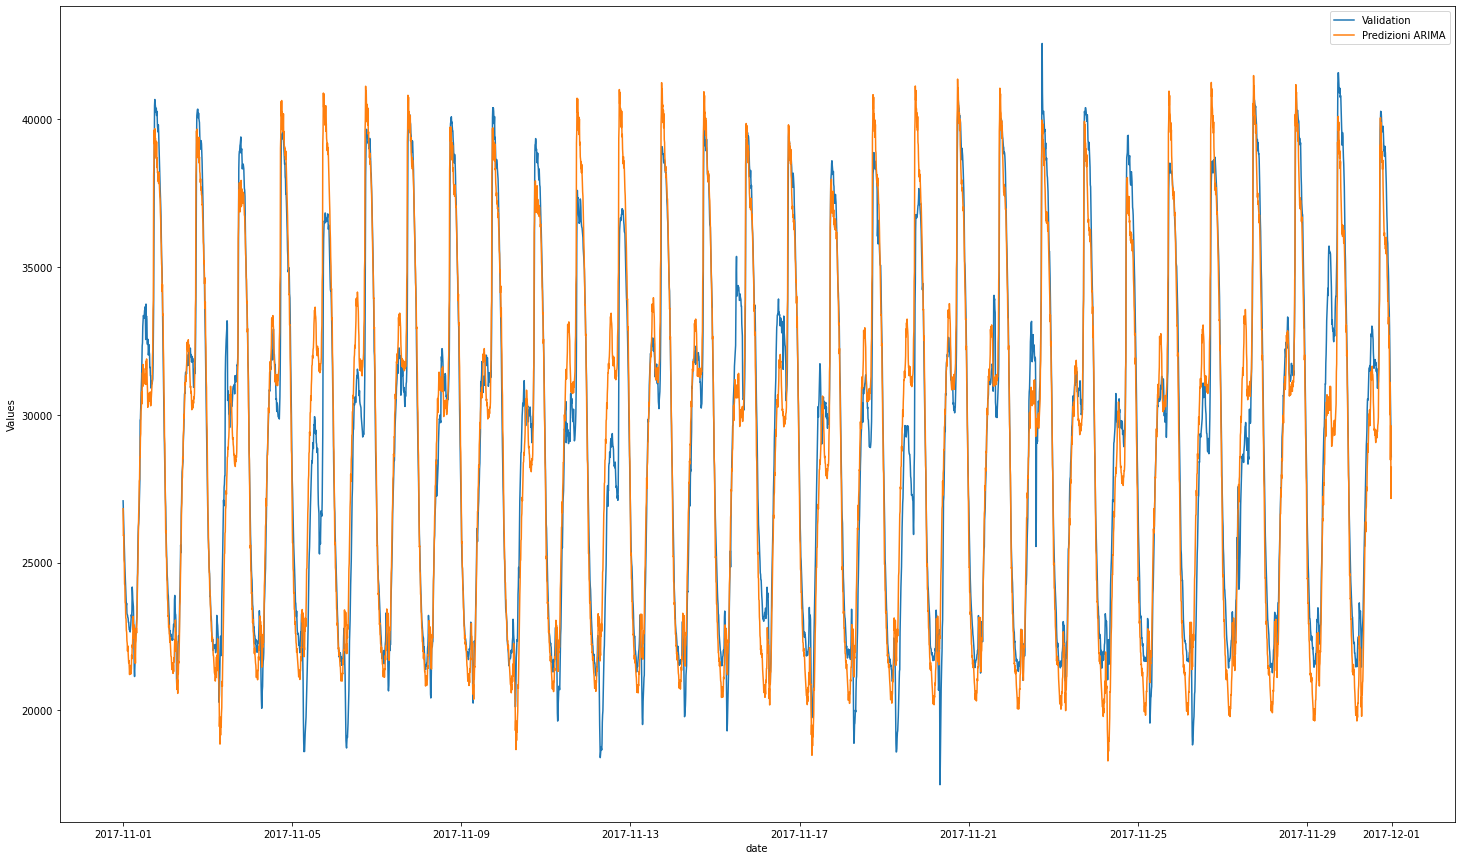

In [256]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))
plt.plot(validation_tot.index, validation_tot.Value, label='Validation')
plt.plot(prova.index, prova.predicted, label='Predizioni ARIMA')

plt.xlabel('date')
plt.ylabel('Values')
plt.legend()

# IMPORT DICEMBRE


In [144]:
path = "/content/drive/MyDrive/Progetto SDMTSA/Tetuan City power consumption.csv"
dataDic = pd.read_csv(path)

In [145]:
dataDic

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964
...,...,...,...,...,...,...,...,...,...
52411,12/30/2017 23:10,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212
52412,12/30/2017 23:20,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152
52413,12/30/2017 23:30,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259
52414,12/30/2017 23:40,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504


In [146]:
dataDic.DateTime = pd.to_datetime(dataDic.DateTime, format='%m/%d/%Y %H:%M')

In [147]:
colonne_da_mantenere = ['DateTime', 'Zone 1 Power Consumption']
dataDic.drop([colonna for colonna in dataDic.columns if colonna not in colonne_da_mantenere], axis=1, inplace=True) 

In [148]:
dataDic.head()

,DateTime,Zone 1 Power Consumption
0,2017-01-01 00:00:00,34055.69620
1,2017-01-01 00:10:00,29814.68354
2,2017-01-01 00:20:00,29128.10127
3,2017-01-01 00:30:00,28228.86076
4,2017-01-01 00:40:00,27335.69620


In [149]:
dataDic = dataDic.rename(columns={'Zone 1 Power Consumption': 'Value', 'DateTime': 'Date'})
dataDic

,Date,Value
0,2017-01-01 00:00:00,34055.69620
1,2017-01-01 00:10:00,29814.68354
2,2017-01-01 00:20:00,29128.10127
3,2017-01-01 00:30:00,28228.86076
4,2017-01-01 00:40:00,27335.69620
...,...,...
52411,2017-12-30 23:10:00,31160.45627
52412,2017-12-30 23:20:00,30430.41825
52413,2017-12-30 23:30:00,29590.87452
52414,2017-12-30 23:40:00,28958.17490


In [150]:
dataDic['Year'] = dataDic.Date.dt.year
dataDic['Month'] = dataDic.Date.dt.month
dataDic['Day'] = dataDic.Date.dt.day
dataDic['Hour'] = dataDic.Date.dt.hour
dataDic['Minute'] = dataDic.Date.dt.minute
dataDic['Second'] = dataDic.Date.dt.second
dataDic['WeekDay'] = dataDic.Date.dt.day_name()
dataDic['Month_Name'] = dataDic.Date.dt.strftime("%B")

dataDic['Num_DayofYear'] = dataDic['Date'].dt.dayofyear
dataDic['Num_DayofWeek'] = dataDic['Date'].dt.dayofweek
dataDic['Num_WeekofYear'] = dataDic['Date'].dt.isocalendar().week

dataDic['Quarter'] = dataDic['Date'].dt.quarter

dataDic['Just_Date'] = dataDic['Date'].dt.date

In [151]:
dataDic.set_index("Date", inplace = True)
dataDic.index.freq = '10T'
dataDic

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:20:00,29128.10127,2017,1,1,0,20,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:30:00,28228.86076,2017,1,1,0,30,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:40:00,27335.69620,2017,1,1,0,40,0,Sunday,January,1,6,52,1,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,31160.45627,2017,12,30,23,10,0,Saturday,December,364,5,52,4,2017-12-30
2017-12-30 23:20:00,30430.41825,2017,12,30,23,20,0,Saturday,December,364,5,52,4,2017-12-30
2017-12-30 23:30:00,29590.87452,2017,12,30,23,30,0,Saturday,December,364,5,52,4,2017-12-30


#### Divisione train test dicembre

In [152]:
# train_dic = dataDic.loc[ "2017-09-01 00:00:00": "2017-11-30 23:50:00"]
# validation_dic = dataDic.loc["2017-12-01 00:00:00" : "2017-12-30 23:50:00"]

In [153]:
train_dic_tot = dataDic.loc[ : "2017-11-30 23:50:00"]
validation_dic_tot = dataDic.loc["2017-12-01 00:00:00" : "2017-12-30 23:50:00"]

##### Salvataggio dataset

In [154]:
# train_dic.to_csv('train_dic.csv', index=False)
# from google.colab import files
# files.download('train_dic.csv')

In [155]:
# validation_dic.to_csv('validation_dic.csv', index=False)
# from google.colab import files
# files.download('validation_dic.csv')

In [156]:
train_dic_tot.to_csv('train_dic_tot.csv', index=True)
from google.colab import files
files.download('train_dic_tot.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [157]:
validation_dic_tot.to_csv('validation_dic_tot.csv', index=True)
from google.colab import files
files.download('validation_dic_tot.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Dicembre ogni 20 minuti TOTALE

### Train Set


In [158]:
train_dic_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:20:00,29128.10127,2017,1,1,0,20,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:30:00,28228.86076,2017,1,1,0,30,0,Sunday,January,1,6,52,1,2017-01-01
2017-01-01 00:40:00,27335.69620,2017,1,1,0,40,0,Sunday,January,1,6,52,1,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 23:10:00,31347.69231,2017,11,30,23,10,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:20:00,30603.07692,2017,11,30,23,20,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 23:30:00,29889.23077,2017,11,30,23,30,0,Thursday,November,334,3,48,4,2017-11-30


In [159]:
train_dic_tot["Num_WeekofYear"] = train_dic_tot["Num_WeekofYear"].replace(52, 0)
train_dic_tot[["Num_WeekofYear","Value"]]

<ipython-input-159-3371d6307a69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dic_tot["Num_WeekofYear"] = train_dic_tot["Num_WeekofYear"].replace(52, 0)


,Num_WeekofYear,Value
Date,,
2017-01-01 00:00:00,0,34055.69620
2017-01-01 00:10:00,0,29814.68354
2017-01-01 00:20:00,0,29128.10127
2017-01-01 00:30:00,0,28228.86076
2017-01-01 00:40:00,0,27335.69620
...,...,...
2017-11-30 23:10:00,48,31347.69231
2017-11-30 23:20:00,48,30603.07692
2017-11-30 23:30:00,48,29889.23077


In [160]:
train_dic_tot0_10 = train_dic_tot[train_dic_tot['Minute'].isin([0, 10])]
train_dic_tot20_30 = train_dic_tot[train_dic_tot['Minute'].isin([20, 30])]
train_dic_tot40_50 = train_dic_tot[train_dic_tot['Minute'].isin([40, 50])]

In [161]:
train_dic_tot0_10

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 01:00:00,25998.98734,2017,1,1,1,0,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 01:10:00,25446.07595,2017,1,1,1,10,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 02:00:00,23003.54430,2017,1,1,2,0,0,Sunday,January,1,6,0,1,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 21:10:00,37267.69231,2017,11,30,21,10,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 22:00:00,35150.76923,2017,11,30,22,0,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 22:10:00,34941.53846,2017,11,30,22,10,0,Thursday,November,334,3,48,4,2017-11-30


In [162]:
grouped_train_dic_tot0_10 = train_dic_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_train_dic_tot20_30 = train_dic_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_train_dic_tot40_50 = train_dic_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})

In [163]:
grouped_train_dic_tot0_10

Value
Hour Num_DayofYear              
0    1              31935.189870
     2              26436.455695
     3              26406.075950
     4              27405.569620
     5              27189.873420
...                          ...
23   330            30732.307695
     331            30744.615385
     332            30621.538465
     333            30344.615385
     334            31707.692310

[8016 rows x 1 columns]

In [164]:
grouped_train_dic_tot0_10_noind = grouped_train_dic_tot0_10.reset_index()
grouped_train_dic_tot20_30_noind = grouped_train_dic_tot20_30.reset_index()
grouped_train_dic_tot40_50_noind = grouped_train_dic_tot40_50.reset_index()

In [165]:
grouped_train_dic_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,1,31935.189870
1,0,2,26436.455695
2,0,3,26406.075950
3,0,4,27405.569620
4,0,5,27189.873420
...,...,...,...
8011,23,330,30732.307695
8012,23,331,30744.615385
8013,23,332,30621.538465
8014,23,333,30344.615385


In [166]:
grouped_train_dic_tot0_10_noind['third_hour'] = 1
grouped_train_dic_tot20_30_noind['third_hour'] = 2
grouped_train_dic_tot40_50_noind['third_hour'] = 3

grouped_train_dic_tot = pd.concat([grouped_train_dic_tot0_10_noind,
                           grouped_train_dic_tot20_30_noind,
                           grouped_train_dic_tot40_50_noind], ignore_index=True)

In [167]:
grouped_train_dic_tot

,Hour,Num_DayofYear,Value,third_hour
0,0,1,31935.189870,1
1,0,2,26436.455695,1
2,0,3,26406.075950,1
3,0,4,27405.569620,1
4,0,5,27189.873420,1
...,...,...,...,...
24043,23,330,27735.384615,3
24044,23,331,28184.615385,3
24045,23,332,28153.846155,3
24046,23,333,27329.230765,3


#### Save dataframes Train


In [168]:
grouped_train_dic_tot.to_csv('grouped_train_dic_tot_20min.csv', index=False)
from google.colab import files
files.download('grouped_train_dic_tot_20min.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [169]:
# grouped_train_dic_tot0_10_noind.to_csv('grouped_train_dic_tot0_10_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_train_dic_tot0_10_noind.csv')

In [170]:
# grouped_train_dic_tot20_30_noind.to_csv('grouped_train_dic_tot20_30_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_train_dic_tot20_30_noind.csv')

In [171]:
# grouped_train_dic_tot40_50_noind.to_csv('grouped_train_dic_tot40_50_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_train_dic_tot40_50_noind.csv')

### Validation Set

In [172]:
validation_dic_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-12-01 00:00:00,27680.60837,2017,12,1,0,0,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:10:00,27011.40684,2017,12,1,0,10,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:20:00,26445.62738,2017,12,1,0,20,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:30:00,25885.93156,2017,12,1,0,30,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:40:00,25277.56654,2017,12,1,0,40,0,Friday,December,335,4,48,4,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,31160.45627,2017,12,30,23,10,0,Saturday,December,364,5,52,4,2017-12-30
2017-12-30 23:20:00,30430.41825,2017,12,30,23,20,0,Saturday,December,364,5,52,4,2017-12-30
2017-12-30 23:30:00,29590.87452,2017,12,30,23,30,0,Saturday,December,364,5,52,4,2017-12-30


In [173]:
validation_dic_tot["Num_WeekofYear"] = validation_dic_tot["Num_WeekofYear"].replace(52, 0)
validation_dic_tot[["Num_WeekofYear","Value"]]

<ipython-input-173-6f007c56b291>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_dic_tot["Num_WeekofYear"] = validation_dic_tot["Num_WeekofYear"].replace(52, 0)


,Num_WeekofYear,Value
Date,,
2017-12-01 00:00:00,48,27680.60837
2017-12-01 00:10:00,48,27011.40684
2017-12-01 00:20:00,48,26445.62738
2017-12-01 00:30:00,48,25885.93156
2017-12-01 00:40:00,48,25277.56654
...,...,...
2017-12-30 23:10:00,0,31160.45627
2017-12-30 23:20:00,0,30430.41825
2017-12-30 23:30:00,0,29590.87452


In [174]:
validation_dic_tot0_10 = validation_dic_tot[validation_dic_tot['Minute'].isin([0, 10])]
validation_dic_tot20_30 = validation_dic_tot[validation_dic_tot['Minute'].isin([20, 30])]
validation_dic_tot40_50 = validation_dic_tot[validation_dic_tot['Minute'].isin([40, 50])]

In [175]:
validation_dic_tot20_30

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-12-01 00:20:00,26445.62738,2017,12,1,0,20,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:30:00,25885.93156,2017,12,1,0,30,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 01:20:00,23641.06464,2017,12,1,1,20,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 01:30:00,23269.96198,2017,12,1,1,30,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 02:20:00,22247.90875,2017,12,1,2,20,0,Friday,December,335,4,48,4,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 21:30:00,35297.33840,2017,12,30,21,30,0,Saturday,December,364,5,0,4,2017-12-30
2017-12-30 22:20:00,34323.95437,2017,12,30,22,20,0,Saturday,December,364,5,0,4,2017-12-30
2017-12-30 22:30:00,33776.42586,2017,12,30,22,30,0,Saturday,December,364,5,0,4,2017-12-30


In [176]:
grouped_validation_dic_tot0_10 = validation_dic_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_validation_dic_tot20_30 = validation_dic_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})
grouped_validation_dic_tot40_50 = validation_dic_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'mean'})

In [177]:
grouped_validation_dic_tot0_10

Value
Hour Num_DayofYear              
0    335            27346.007605
     336            26564.258555
     337            27349.049430
     338            25666.920155
     339            26114.068440
...                          ...
23   360            30813.688215
     361            30527.756655
     362            31574.144485
     363            31628.897340
     364            31659.315585

[720 rows x 1 columns]

In [178]:
grouped_validation_dic_tot0_10_noind = grouped_validation_dic_tot0_10.reset_index()
grouped_validation_dic_tot20_30_noind = grouped_validation_dic_tot20_30.reset_index()
grouped_validation_dic_tot40_50_noind = grouped_validation_dic_tot40_50.reset_index()

In [179]:
grouped_validation_dic_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,335,27346.007605
1,0,336,26564.258555
2,0,337,27349.049430
3,0,338,25666.920155
4,0,339,26114.068440
...,...,...,...
715,23,360,30813.688215
716,23,361,30527.756655
717,23,362,31574.144485
718,23,363,31628.897340


In [180]:
grouped_validation_dic_tot0_10_noind['third_hour'] = 1
grouped_validation_dic_tot20_30_noind['third_hour'] = 2
grouped_validation_dic_tot40_50_noind['third_hour'] = 3

grouped_validation_dic_tot = pd.concat([grouped_validation_dic_tot0_10_noind,
                           grouped_validation_dic_tot20_30_noind,
                           grouped_validation_dic_tot40_50_noind], ignore_index=True)

In [181]:
grouped_validation_dic_tot

,Hour,Num_DayofYear,Value,third_hour
0,0,335,27346.007605,1
1,0,336,26564.258555,1
2,0,337,27349.049430,1
3,0,338,25666.920155,1
4,0,339,26114.068440,1
...,...,...,...,...
2155,23,360,27863.117870,3
2156,23,361,28155.133080,3
2157,23,362,28538.403040,3
2158,23,363,28806.083650,3


#### Save Dataframes Validation

In [182]:
grouped_validation_dic_tot.to_csv('grouped_validation_dic_tot_20min.csv', index=False)
from google.colab import files
files.download('grouped_validation_dic_tot_20min.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [183]:
# grouped_validation_dic_tot0_10_noind.to_csv('grouped_validation_dic_tot0_10_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_validation_dic_tot0_10_noind.csv')

In [184]:
# grouped_validation_dic_tot20_30_noind.to_csv('grouped_validation_dic_tot20_30_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_validation_dic_tot20_30_noind.csv')

In [185]:
# grouped_validation_dic_tot40_50_noind.to_csv('grouped_validation_dic_tot40_50_noind.csv', index=False)
# from google.colab import files
# files.download('grouped_validation_dic_tot40_50_noind.csv')

### REVERT DICEMBRE TOT
train da inizio a fine novembre, validation da 1 a 30 dicembre

In [186]:
train_dic_tot0_10

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-01-01 00:00:00,34055.69620,2017,1,1,0,0,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 00:10:00,29814.68354,2017,1,1,0,10,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 01:00:00,25998.98734,2017,1,1,1,0,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 01:10:00,25446.07595,2017,1,1,1,10,0,Sunday,January,1,6,0,1,2017-01-01
2017-01-01 02:00:00,23003.54430,2017,1,1,2,0,0,Sunday,January,1,6,0,1,2017-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30 21:10:00,37267.69231,2017,11,30,21,10,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 22:00:00,35150.76923,2017,11,30,22,0,0,Thursday,November,334,3,48,4,2017-11-30
2017-11-30 22:10:00,34941.53846,2017,11,30,22,10,0,Thursday,November,334,3,48,4,2017-11-30


In [187]:
grouped_var_train_dic_tot0_10 = train_dic_tot0_10.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_train_dic_tot20_30 = train_dic_tot20_30.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})
grouped_var_train_dic_tot40_50 = train_dic_tot40_50.groupby(["Hour", "Num_DayofYear"]).agg({'Value':'var'})

In [188]:
grouped_var_train_dic_tot0_10

Value
Hour Num_DayofYear              
0    1              8.993094e+06
     2              1.429432e+05
     3              1.302437e+05
     4              1.271612e+05
     5              4.492080e+05
...                          ...
23   330            1.969988e+05
     331            2.911432e+05
     332            2.375195e+05
     333            2.375195e+05
     334            2.592000e+05

[8016 rows x 1 columns]

In [189]:
grouped_var_train_dic_tot0_10_noind = grouped_var_train_dic_tot0_10.reset_index()
grouped_var_train_dic_tot20_30_noind = grouped_var_train_dic_tot20_30.reset_index()
grouped_var_train_dic_tot40_50_noind = grouped_var_train_dic_tot40_50.reset_index()

In [190]:
grouped_var_train_dic_tot0_10_noind

,Hour,Num_DayofYear,Value
0,0,1,8.993094e+06
1,0,2,1.429432e+05
2,0,3,1.302437e+05
3,0,4,1.271612e+05
4,0,5,4.492080e+05
...,...,...,...
8011,23,330,1.969988e+05
8012,23,331,2.911432e+05
8013,23,332,2.375195e+05
8014,23,333,2.375195e+05


In [191]:
grouped_median_train_dic_tot0_10 = grouped_var_train_dic_tot0_10_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_dic_tot20_30 = grouped_var_train_dic_tot20_30_noind.groupby(["Hour"]).agg({'Value':'median'})
grouped_median_train_dic_tot40_50 = grouped_var_train_dic_tot40_50_noind.groupby(["Hour"]).agg({'Value':'median'})

In [192]:
grouped_median_train_dic_tot0_10

,Value
Hour,
0,206370.818811
1,79648.192465
2,21663.791918
3,7360.557802
4,10813.885047
5,55112.385664
6,50747.904829
7,114944.426706
8,200579.822170


In [193]:
grouped_median_train_dic_tot0_10_noind = grouped_median_train_dic_tot0_10.reset_index()
grouped_median_train_dic_tot20_30_noind = grouped_median_train_dic_tot20_30.reset_index()
grouped_median_train_dic_tot40_50_noind = grouped_median_train_dic_tot40_50.reset_index()

In [194]:
grouped_median_train_dic_tot0_10_noind

,Hour,Value
0,0,206370.818811
1,1,79648.192465
2,2,21663.791918
3,3,7360.557802
4,4,10813.885047
5,5,55112.385664
6,6,50747.904829
7,7,114944.426706
8,8,200579.822170
9,9,173763.151156


In [195]:
grouped_median_train_dic_tot0_10_noind = grouped_median_train_dic_tot0_10_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_dic_tot20_30_noind = grouped_median_train_dic_tot20_30_noind.rename(columns = {'Value' : 'var'})
grouped_median_train_dic_tot40_50_noind = grouped_median_train_dic_tot40_50_noind.rename(columns = {'Value' : 'var'})

In [196]:
grouped_median_train_dic_tot0_10_noind

,Hour,var
0,0,206370.818811
1,1,79648.192465
2,2,21663.791918
3,3,7360.557802
4,4,10813.885047
5,5,55112.385664
6,6,50747.904829
7,7,114944.426706
8,8,200579.822170
9,9,173763.151156


In [197]:
import numpy as np

def generate_sequence(mean, variance, num_samples):
    return np.linspace(mean - np.sqrt(variance), mean + np.sqrt(variance), num_samples)

In [198]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
  print(f'Selected file: {filename}')


Saving grouped_pred_dicembre_ord_20min.csv to grouped_pred_dicembre_ord_20min.csv
Selected file: grouped_pred_dicembre_ord_20min.csv


In [199]:
import pandas as pd

df_predictions = pd.read_csv(filename)
df_predictions

,Unnamed: 0,Num_DayofYear,Hour,third_hour,Value,predicted
0,1,335,0,1,27346.007605,26367.708460
1,31,335,0,2,26165.779470,25511.563952
2,61,335,0,3,25076.806085,24628.290083
3,91,335,1,1,24322.433460,23934.391445
4,121,335,1,2,23455.513310,23364.705091
...,...,...,...,...,...,...
2155,2040,364,22,2,34050.190115,32787.244549
2156,2070,364,22,3,33101.140685,32110.456076
2157,2100,364,23,1,31659.315585,30552.265226
2158,2130,364,23,2,30010.646385,29059.307629


In [200]:
df_predictions = df_predictions.drop('Unnamed: 0', axis=1)

In [201]:
df_predictions

,Num_DayofYear,Hour,third_hour,Value,predicted
0,335,0,1,27346.007605,26367.708460
1,335,0,2,26165.779470,25511.563952
2,335,0,3,25076.806085,24628.290083
3,335,1,1,24322.433460,23934.391445
4,335,1,2,23455.513310,23364.705091
...,...,...,...,...,...
2155,364,22,2,34050.190115,32787.244549
2156,364,22,3,33101.140685,32110.456076
2157,364,23,1,31659.315585,30552.265226
2158,364,23,2,30010.646385,29059.307629


In [202]:
# grouped_median_train_dic_tot0_30_noind = grouped_median_train_dic_tot0_30_noind.drop('index', axis=1)
# grouped_median_train_dic_tot30_60_noind = grouped_median_train_dic_tot30_60_noind.drop('index', axis=1)

In [203]:
grouped_median_train_dic_tot0_10_noind

,Hour,var
0,0,206370.818811
1,1,79648.192465
2,2,21663.791918
3,3,7360.557802
4,4,10813.885047
5,5,55112.385664
6,6,50747.904829
7,7,114944.426706
8,8,200579.822170
9,9,173763.151156


In [204]:
df_predictions1 = df_predictions.loc[df_predictions["third_hour"] == 1]
df_predictions2 = df_predictions.loc[df_predictions["third_hour"] == 2]
df_predictions3 = df_predictions.loc[df_predictions["third_hour"] == 3]

In [205]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted
0,335,0,1,27346.007605,26367.708460
3,335,1,1,24322.433460,23934.391445
6,335,2,1,22387.832700,22499.316929
9,335,3,1,21739.923955,21696.940234
12,335,4,1,21536.121670,21415.665647
...,...,...,...,...,...
2145,364,19,1,37694.296580,38180.067425
2148,364,20,1,37171.102660,35972.688415
2151,364,21,1,36088.212930,35788.018388
2154,364,22,1,34828.897340,33458.316160


In [206]:
df_predictions1 = df_predictions1.merge(grouped_median_train_dic_tot0_10_noind, on = "Hour")
df_predictions2 = df_predictions2.merge(grouped_median_train_dic_tot20_30_noind, on = "Hour")
df_predictions3 = df_predictions3.merge(grouped_median_train_dic_tot40_50_noind, on = "Hour")

In [207]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,1,27346.007605,26367.708460,206370.818811
1,336,0,1,26564.258555,26468.582205,206370.818811
2,337,0,1,27349.049430,26942.523450,206370.818811
3,338,0,1,25666.920155,25940.911525,206370.818811
4,339,0,1,26114.068440,26119.542749,206370.818811
...,...,...,...,...,...,...
715,360,23,1,30813.688215,30139.657004,295857.988757
716,361,23,1,30527.756655,29881.164476,295857.988757
717,362,23,1,31574.144485,29912.009500,295857.988757
718,363,23,1,31628.897340,30110.327456,295857.988757


In [208]:
df_predictions1 = df_predictions1.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions2 = df_predictions2.sort_values(by=['Num_DayofYear', 'Hour'])
df_predictions3 = df_predictions3.sort_values(by=['Num_DayofYear', 'Hour'])

In [209]:
df_predictions1 = df_predictions1.reset_index(drop = True)
df_predictions2 = df_predictions2.reset_index(drop = True)
df_predictions3 = df_predictions3.reset_index(drop = True)

In [210]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,1,27346.007605,26367.708460,206370.818811
1,335,1,1,24322.433460,23934.391445,79648.192465
2,335,2,1,22387.832700,22499.316929,21663.791918
3,335,3,1,21739.923955,21696.940234,7360.557802
4,335,4,1,21536.121670,21415.665647,10813.885047
...,...,...,...,...,...,...
715,364,19,1,37694.296580,38180.067425,189454.860836
716,364,20,1,37171.102660,35972.688415,36042.935382
717,364,21,1,36088.212930,35788.018388,48214.634216
718,364,22,1,34828.897340,33458.316160,153372.781704


##### Predictions 1

In [211]:
df_predictions1_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [212]:
df_predictions1

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,1,27346.007605,26367.708460,206370.818811
1,335,1,1,24322.433460,23934.391445,79648.192465
2,335,2,1,22387.832700,22499.316929,21663.791918
3,335,3,1,21739.923955,21696.940234,7360.557802
4,335,4,1,21536.121670,21415.665647,10813.885047
...,...,...,...,...,...,...
715,364,19,1,37694.296580,38180.067425,189454.860836
716,364,20,1,37171.102660,35972.688415,36042.935382
717,364,21,1,36088.212930,35788.018388,48214.634216
718,364,22,1,34828.897340,33458.316160,153372.781704


In [213]:
def decompose(row, df_predictions1_final):
  index = row.name

  Num_DayofYear = df_predictions1.loc[index]['Num_DayofYear']
  hour = df_predictions1.loc[index]['Hour']

  gens = generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions1.loc[index]['predicted'] > df_predictions1.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(0, 20, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions1_final = df_predictions1_final.append(new_row, ignore_index=True)
  return df_predictions1_final

In [217]:
df_predictions1_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions1.iterrows():
    df_predictions1_final = decompose(row, df_predictions1_final)

In [218]:
generate_sequence(df_predictions1.loc[index]['predicted'], df_predictions1.loc[index]['var'], 2)

array([30008.33693261, 31096.19352014])

In [219]:
df_predictions1_final['Num_DayofYear'] = df_predictions1_final['Num_DayofYear'].astype(int)
df_predictions1_final['Hour'] = df_predictions1_final['Hour'].astype(int)
df_predictions1_final['Minute'] = df_predictions1_final['Minute'].astype(int)

In [220]:
df_predictions1_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26821.989011
1,335,0,10,25913.427909
2,335,1,0,24216.611558
3,335,1,10,23652.171331
4,335,2,0,22646.503178
...,...,...,...,...
1435,364,21,10,35568.440078
1436,364,22,0,33849.944532
1437,364,22,10,33066.687788
1438,364,23,0,30008.336933


##### Predictions 2

In [221]:
df_predictions2

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,2,26165.779470,25511.563952,180306.514377
1,335,1,2,23455.513310,23364.705091,59127.738789
2,335,2,2,22138.403045,22136.003408,17462.082561
3,335,3,2,21654.752855,21577.492869,11412.879319
4,335,4,2,21514.828895,21366.014921,19453.665110
...,...,...,...,...,...,...
715,364,19,2,37615.209125,37014.835012,61927.541094
716,364,20,2,37104.182510,35738.485283,16656.402293
717,364,21,2,35455.513305,35021.202561,94184.540494
718,364,22,2,34050.190115,32787.244549,272547.202960


In [222]:
df_predictions2_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [223]:
def decompose(row, df_predictions2_final):
  index = row.name

  Num_DayofYear = df_predictions2.loc[index]['Num_DayofYear']
  hour = df_predictions2.loc[index]['Hour']

  gens = generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions2.loc[index]['predicted'] > df_predictions2.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(20, 40, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions2_final = df_predictions2_final.append(new_row, ignore_index=True)
  return df_predictions2_final

In [224]:
df_predictions2_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions2.iterrows():
    df_predictions2_final = decompose(row, df_predictions2_final)

In [225]:
generate_sequence(df_predictions2.loc[index]['predicted'], df_predictions2.loc[index]['var'], 2)

array([28474.8931152 , 29643.72214337])

In [226]:
df_predictions2_final['Num_DayofYear'] = df_predictions2_final['Num_DayofYear'].astype(int)
df_predictions2_final['Hour'] = df_predictions2_final['Hour'].astype(int)
df_predictions2_final['Minute'] = df_predictions2_final['Minute'].astype(int)

In [227]:
df_predictions2_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,20,25936.189098
1,335,0,30,25086.938807
2,335,1,20,23607.867051
3,335,1,30,23121.543131
4,335,2,20,22268.147582
...,...,...,...,...
1435,364,21,30,34714.307562
1436,364,22,20,33309.305084
1437,364,22,30,32265.184013
1438,364,23,20,28474.893115


##### Predictions 3

In [228]:
df_predictions3

,Num_DayofYear,Hour,third_hour,Value,predicted,var
0,335,0,3,25076.806085,24628.290083,124700.750442
1,335,1,3,22740.684415,22902.452854,39178.766418
2,335,2,3,21885.931555,22072.093698,11923.827194
3,335,3,3,21563.498095,21316.083033,10942.687178
4,335,4,3,21435.741445,21627.953564,56534.879120
...,...,...,...,...,...,...
715,364,19,3,37231.939165,36213.310471,23210.498393
716,364,20,3,36751.330795,35617.715921,28434.673341
717,364,21,3,34530.798480,34162.726629,99886.384187
718,364,22,3,33101.140685,32110.456076,324891.287633


In [229]:
df_predictions3_final = pd.DataFrame(columns = ['Num_DayofYear', 'Hour', 'Minute', 'predicted'])

In [230]:
def decompose(row, df_predictions3_final):
  index = row.name

  Num_DayofYear = df_predictions3.loc[index]['Num_DayofYear']
  hour = df_predictions3.loc[index]['Hour']

  gens = generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

  if(index != 719):
    if(df_predictions3.loc[index]['predicted'] > df_predictions3.loc[index+1]['predicted']):
      gens = np.sort(gens)[::-1]

  i = 0
  
  for minute in range(40, 60, 10):
      new_row = {'Num_DayofYear': int(Num_DayofYear), 'Hour': int(hour), 'Minute': int(minute), 'predicted': gens[i]}
      i += 1
      df_predictions3_final = df_predictions3_final.append(new_row, ignore_index=True)
  return df_predictions3_final

In [231]:
df_predictions3_final = pd.DataFrame(columns=['Num_DayofYear', 'Hour', 'Minute', 'predicted'])
for index, row in df_predictions3.iterrows():
    df_predictions3_final = decompose(row, df_predictions3_final)

In [232]:
generate_sequence(df_predictions3.loc[index]['predicted'], df_predictions3.loc[index]['var'], 2)

array([27170.82691218, 28219.57379133])

In [233]:
df_predictions3_final['Num_DayofYear'] = df_predictions3_final['Num_DayofYear'].astype(int)
df_predictions3_final['Hour'] = df_predictions3_final['Hour'].astype(int)
df_predictions3_final['Minute'] = df_predictions3_final['Minute'].astype(int)

In [234]:
df_predictions3_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,40,24981.420017
1,335,0,50,24275.160149
2,335,1,40,23100.389123
3,335,1,50,22704.516586
4,335,2,40,22181.289976
...,...,...,...,...
1435,364,21,50,33846.678556
1436,364,22,40,32680.448434
1437,364,22,50,31540.463719
1438,364,23,40,27170.826912


##### Merge

In [235]:
df_predictions_final = pd.concat([df_predictions1_final, df_predictions2_final, df_predictions3_final])

In [236]:
df_predictions_final= df_predictions_final.sort_values(by="Minute", ascending=True)

In [237]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26821.989011
1146,358,21,0,35912.692658
586,347,5,0,21219.659963
588,347,6,0,23192.800786
1144,358,20,0,36188.020232
...,...,...,...,...
293,341,2,50,21918.465233
849,352,16,50,32587.849313
851,352,17,50,40353.127914
837,352,10,50,30025.252680


In [238]:
df_predictions_final = df_predictions_final.sort_values(["Num_DayofYear", "Hour"])

In [239]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26821.989011
1,335,0,10,25913.427909
0,335,0,20,25936.189098
1,335,0,30,25086.938807
0,335,0,40,24981.420017
...,...,...,...,...
1439,364,23,10,31096.193520
1438,364,23,20,28474.893115
1439,364,23,30,29643.722143
1438,364,23,40,27170.826912


In [240]:
df_predictions_final = df_predictions_final.reset_index(drop=True)

In [241]:
df_predictions_final

,Num_DayofYear,Hour,Minute,predicted
0,335,0,0,26821.989011
1,335,0,10,25913.427909
2,335,0,20,25936.189098
3,335,0,30,25086.938807
4,335,0,40,24981.420017
...,...,...,...,...
4315,364,23,10,31096.193520
4316,364,23,20,28474.893115
4317,364,23,30,29643.722143
4318,364,23,40,27170.826912


In [242]:
validation_dic_tot

,Value,Year,Month,Day,Hour,Minute,Second,WeekDay,Month_Name,Num_DayofYear,Num_DayofWeek,Num_WeekofYear,Quarter,Just_Date
Date,,,,,,,,,,,,,,
2017-12-01 00:00:00,27680.60837,2017,12,1,0,0,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:10:00,27011.40684,2017,12,1,0,10,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:20:00,26445.62738,2017,12,1,0,20,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:30:00,25885.93156,2017,12,1,0,30,0,Friday,December,335,4,48,4,2017-12-01
2017-12-01 00:40:00,25277.56654,2017,12,1,0,40,0,Friday,December,335,4,48,4,2017-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,31160.45627,2017,12,30,23,10,0,Saturday,December,364,5,0,4,2017-12-30
2017-12-30 23:20:00,30430.41825,2017,12,30,23,20,0,Saturday,December,364,5,0,4,2017-12-30
2017-12-30 23:30:00,29590.87452,2017,12,30,23,30,0,Saturday,December,364,5,0,4,2017-12-30


##### Valutazione

In [243]:
validation_dic_tot["Value"]

Date
2017-12-01 00:00:00    27680.60837
2017-12-01 00:10:00    27011.40684
2017-12-01 00:20:00    26445.62738
2017-12-01 00:30:00    25885.93156
2017-12-01 00:40:00    25277.56654
                          ...     
2017-12-30 23:10:00    31160.45627
2017-12-30 23:20:00    30430.41825
2017-12-30 23:30:00    29590.87452
2017-12-30 23:40:00    28958.17490
2017-12-30 23:50:00    28349.80989
Freq: 10T, Name: Value, Length: 4320, dtype: float64

In [244]:
df_predictions_final["predicted"]

0       26821.989011
1       25913.427909
2       25936.189098
3       25086.938807
4       24981.420017
            ...     
4315    31096.193520
4316    28474.893115
4317    29643.722143
4318    27170.826912
4319    28219.573791
Name: predicted, Length: 4320, dtype: float64

In [245]:
from sklearn import metrics

mae_value = metrics.mean_absolute_error(validation_dic_tot["Value"], df_predictions_final["predicted"])
print("MAE value is:", mae_value)

MAE value is: 898.5390017353936


# CREAZIONE DATASET PER PREDIZIONI

In [ ]:
start_date = '2017-12-01 00:00:00'
end_date = '2017-12-30 23:59:59'

date_range = pd.date_range(start=start_date, end=end_date, freq='10min')

predizioni_df = df_predictions_final.copy()
predizioni_df['date'] = date_range
predizioni_df = predizioni_df.set_index('date')

In [ ]:
predizioni_df

,Num_DayofYear,Hour,Minute,predicted
date,,,,
2017-12-01 00:00:00,335,0,0,26821.989011
2017-12-01 00:10:00,335,0,10,25913.427909
2017-12-01 00:20:00,335,0,20,25936.189098
2017-12-01 00:30:00,335,0,30,25086.938807
2017-12-01 00:40:00,335,0,40,24981.420017
...,...,...,...,...
2017-12-30 23:10:00,364,23,10,31096.193520
2017-12-30 23:20:00,364,23,20,28474.893115
2017-12-30 23:30:00,364,23,30,29643.722143


In [ ]:
predizioni_df = predizioni_df.drop(columns = ["Num_DayofYear", "Hour", "Minute"])

In [ ]:
predizioni_df

,predicted
date,
2017-12-01 00:00:00,26821.989011
2017-12-01 00:10:00,25913.427909
2017-12-01 00:20:00,25936.189098
2017-12-01 00:30:00,25086.938807
2017-12-01 00:40:00,24981.420017
...,...
2017-12-30 23:10:00,31096.193520
2017-12-30 23:20:00,28474.893115
2017-12-30 23:30:00,29643.722143


In [ ]:
predizioni_df = predizioni_df.rename(columns={'predicted': 'ARIMA'})

In [ ]:
predizioni_df

,ARIMA
date,
2017-12-01 00:00:00,26821.989011
2017-12-01 00:10:00,25913.427909
2017-12-01 00:20:00,25936.189098
2017-12-01 00:30:00,25086.938807
2017-12-01 00:40:00,24981.420017
...,...
2017-12-30 23:10:00,31096.193520
2017-12-30 23:20:00,28474.893115
2017-12-30 23:30:00,29643.722143


In [ ]:
# mae_value = metrics.mean_absolute_error(validation_dic_tot["Value"], predizioni_df["ARIMA"])
# print("MAE value is:", mae_value)

MAE value is: 898.5390017353936


In [ ]:
predizioni_df.to_csv('predizioni_df_ARIMA.csv', index=True)
from google.colab import files
files.download('predizioni_df_ARIMA.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>